In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Prints the name of the GPU


True
Tesla T4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Imports and Setup
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

#  GPU Setup and Seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

#  Load and Prepare Data
!gdown "https://drive.google.com/uc?id=1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23"
data = pd.read_csv('6000labeled_sample_data_all.csv', encoding='ISO-8859-1')
posts = data['cleaned_text'].tolist()
comments = data['cleaned_body'].tolist()
labels = data['label_agreement'].map({-1: 0, 0: 1, 1: 2}).tolist()  # Map labels

#  Initialize Tokenizer and Tokenize Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def smart_truncate_and_tokenize(posts, comments, max_length=512):
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3
    input_ids, attention_masks = [], []

    for post, comment in zip(posts, comments):
        post_tokens = tokenizer.encode(post, add_special_tokens=False, truncation=True, max_length=post_max_length)
        comment_tokens = tokenizer.encode(comment, add_special_tokens=False, truncation=True, max_length=comment_max_length)
        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        padded_tokens = combined_tokens + [tokenizer.pad_token_id] * (max_length - len(combined_tokens))
        attention_mask = [1] * len(combined_tokens) + [0] * (max_length - len(combined_tokens))
        input_ids.append(padded_tokens)
        attention_masks.append(attention_mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    posts, comments, labels, test_size=0.1, random_state=42, stratify=labels
)

train_input_ids, train_attention_masks = smart_truncate_and_tokenize(train_posts, train_comments)
val_input_ids, val_attention_masks = smart_truncate_and_tokenize(val_posts, val_comments)

#  Prepare Dataset and DataLoaders
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TextDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TextDataset(val_input_ids, val_attention_masks, val_labels)






# DataLoader with reduced num_workers
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,  # Adjusted for your environment
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Model with increased dropout
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)









# freezing layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for layer in model.bert.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False
model.to(device)

class_weights = torch.FloatTensor([len(train_labels) / (3 * count) for count in np.bincount(train_labels)]).to(device)




# Optimizer with increased weight decay
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=3e-5,
    weight_decay=0.02
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-5,  # Refined maximum LR
    steps_per_epoch=len(train_loader),
    epochs=5,
    anneal_strategy='linear'
)



#optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=3e-5, weight_decay=0.01)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-5, epochs=5, steps_per_epoch=len(train_loader))




# Define Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=class_weights, )

# Training Loop with Early Stopping
best_f1 = 0
patience = 3
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}



for epoch in range(5):
    print(f"\nEpoch {epoch + 1}")
    model.train()
    train_loss, train_true, train_pred = 0, [], []
    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: batch[key].to(device) for key in ['input_ids', 'attention_mask']}
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    train_f1 = f1_score(train_true, train_pred, average='weighted')
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_f1'].append(train_f1)

    model.eval()
    val_loss, val_true, val_pred = 0, [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: batch[key].to(device) for key in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    val_f1 = f1_score(val_true, val_pred, average='weighted')
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_f1'].append(val_f1)

    print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved new best model!")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


# Add detailed classification metrics
print("\nPer-class Metrics (Validation):")
print(classification_report(val_true, val_pred, target_names=['Disagree', 'Neutral', 'Agree']))


Using device: cuda
Downloading...
From: https://drive.google.com/uc?id=1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23
To: /content/6000labeled_sample_data_all.csv
100% 65.2M/65.2M [00:01<00:00, 50.0MB/s]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


Validating: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Train F1: 0.2818, Val F1: 0.1839
Saved new best model!

Epoch 2


Validating: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Train F1: 0.1760, Val F1: 0.2297
Saved new best model!

Epoch 3


Validating: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Train F1: 0.2139, Val F1: 0.2175
No improvement for 1 epochs.

Epoch 4


Validating: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Train F1: 0.2340, Val F1: 0.2009
No improvement for 2 epochs.

Epoch 5


Validating: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]

Train F1: 0.2314, Val F1: 0.1951
No improvement for 3 epochs.
Early stopping triggered.


In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import shutil

# 2. GPU Setup and Seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# 3. Load and prepare data
#url for 6000= https://drive.google.com/file/d/1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23/view?usp=drive_link
!gdown "https://drive.google.com/uc?id=1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23"
print("\n=== Loading Dataset ===")
data = pd.read_csv('6000labeled_sample_data_all.csv', encoding='ISO-8859-1')

# Print initial statistics
print("\nLabel distribution:")
label_dist = data['label_agreement'].value_counts()
print(label_dist)


posts = data['cleaned_text'].tolist()
comments = data['cleaned_body'].tolist()
labels = data['label_agreement'].map({-1: 0, 0: 1, 1: 2}).tolist()  # Convert to 0 (disagree), 1 (neutral), 2 (agree)

# Print initial statistics
print("\nLabel distribution:")
label_dist = pd.Series(labels).value_counts()
print(label_dist)
print("\nLabel meanings:")
print("0: Disagree (-1)")
print("1: Neutral (0)")
print("2: Agree (1)")

# 4. Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def smart_truncate_and_tokenize(posts, comments, max_length=512):
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3

    truncated_pairs = []
    for post, comment in zip(posts, comments):
        post_tokens = tokenizer.encode(
            post,
            add_special_tokens=False,
            truncation=True,
            max_length=post_max_length
        )
        comment_tokens = tokenizer.encode(
            comment,
            add_special_tokens=False,
            truncation=True,
            max_length=comment_max_length
        )
        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        truncated_pairs.append(combined_tokens)

    padded_pairs = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in truncated_pairs],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    attention_masks = (padded_pairs != tokenizer.pad_token_id).long()
    return {'input_ids': padded_pairs, 'attention_mask': attention_masks}


# 5. Split and tokenize dataset
train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    posts, comments, labels, test_size=0.1, random_state=42, stratify=labels
)

print(f"\nTraining set size: {len(train_posts)}")
print(f"Validation set size: {len(val_posts)}")

train_tokens = smart_truncate_and_tokenize(train_posts, train_comments)
val_tokens = smart_truncate_and_tokenize(val_posts, val_comments)

train_tokens['labels'] = torch.tensor(train_labels, dtype=torch.long)
val_tokens['labels'] = torch.tensor(val_labels, dtype=torch.long)

# 6. Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['labels'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.tokens.items()}

train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)

#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


Using device: cuda
Downloading...
From: https://drive.google.com/uc?id=1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23
To: /content/6000labeled_sample_data_all.csv
100% 65.2M/65.2M [00:00<00:00, 138MB/s]

=== Loading Dataset ===

Label distribution:
label_agreement
-1    2847
 0    2044
 1    1109
Name: count, dtype: int64

Label distribution:
0    2847
1    2044
2    1109
Name: count, dtype: int64

Label meanings:
0: Disagree (-1)
1: Neutral (0)
2: Agree (1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Training set size: 5400
Validation set size: 600


In [ ]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    drop_last=False
)

# Cell 2: Initialize model with improved settings for preventing overfitting
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    hidden_dropout_prob=0.3,    # Increase dropout
    attention_probs_dropout_prob=0.3
)

# Freeze layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for layer in model.bert.encoder.layer[:6]:  # Freeze first 8 layers
    for param in layer.parameters():
        param.requires_grad = False

model.to(device)

# Cell 3: Set up optimizer and calculate class weights
# Calculate class weights for handling imbalance
labels_array = np.array(labels)
class_counts = np.bincount(labels_array)
total_samples = len(labels_array)
class_weights = torch.FloatTensor([total_samples/(len(class_counts) * count) for count in class_counts]).to(device)
print(f"Class weights: {class_weights}")

# Optimizer setup with weight decay
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5,
    weight_decay=0.01,
    eps=1e-8
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=1,
    verbose=True,
    min_lr=1e-6
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([0.7025, 0.9785, 1.8034], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 7. Create DataLoaders with adjusted batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Increased for larger dataset
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    drop_last=False
)

# 8. Model initialization with adjusted dropout
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    hidden_dropout_prob=0.3,    # Reduced dropout for larger dataset
    attention_probs_dropout_prob=0.3
)

# 9. Freeze layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for layer in model.bert.encoder.layer[:8]:  # Freeze fewer layers (6 instead of 8)
    for param in layer.parameters():
        param.requires_grad = False

model.to(device)

# 10. Set up optimizer with class weights
# Calculate class weights based on distribution
total_samples = len(train_labels)
class_counts = np.bincount(train_labels)
class_weights = torch.FloatTensor([
    total_samples / (len(class_counts) * count) for count in class_counts
]).to(device)
print(f"Class weights: {class_weights}")

# Optimizer setup
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=5e-6,  # Slightly higher learning rate for larger dataset
    weight_decay=0.02,
    eps=1e-8
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,  # Increased patience
    verbose=True,
    min_lr=1e-6
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([0.7026, 0.9783, 1.8036], device='cuda:0')


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Increased batch size for stability
    shuffle=True,
    pin_memory=True,
    num_workers=4,  # Increased workers for faster data loading
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    drop_last=False
)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    hidden_dropout_prob=0.2,  # Reduced dropout
    attention_probs_dropout_prob=0.2
)

# Freeze embeddings and the first  encoder layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for layer in model.bert.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False


# 10. Set up optimizer with class weights
# Calculate class weights based on distribution
total_samples = len(train_labels)
class_counts = np.bincount(train_labels)
class_weights = torch.FloatTensor([
    total_samples / (len(class_counts) * count) for count in class_counts
]).to(device)
print(f"Class weights: {class_weights}")

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=3e-6,  # Slightly reduced learning rate
    weight_decay=0.01,  # Reduced weight decay for better generalization
    eps=1e-8
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-5,  # Use a cyclic scheduler with a maximum learning rate
    steps_per_epoch=len(train_loader),
    epochs=5,
    anneal_strategy='linear'
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([0.7026, 0.9783, 1.8036], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch.nn.functional as F

# Training setup
epochs = 5
best_f1 = 0
patience = 3
patience_counter = 0

# Loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Metrics tracking
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_true_labels.extend(labels.cpu().numpy())
        train_pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    print(f"\nEpoch {epoch + 1} Metrics:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_f1,
            'history': history
        }, 'best_model_weighted_ce.pt')
        print("\nSaved new best model!")


Epoch 1/5


Training:   0%|          | 0/338 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# First, define the Focal Loss class
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=class_weights, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# Training setup
epochs = 5
best_f1 = 0
patience = 3
patience_counter = 0

# Initialize Focal Loss
criterion = FocalLoss(alpha=class_weights, gamma=2)

# Metrics tracking
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_true_labels.extend(labels.cpu().numpy())
        train_pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    print(f"\nEpoch {epoch + 1} Metrics:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_f1,
            'history': history
        }, 'best_model_focal_loss.pt')
        print("\nSaved new best model!")

# After training, print class-wise metrics
print("\nPer-class Classification Report:")
print(classification_report(val_true_labels, val_pred_labels,
                          target_names=['Disagree', 'Neutral', 'Agree'],
                          digits=4))


Epoch 1/5


Training:   0%|          | 0/338 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# First, define the Focal Loss class
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=class_weights, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# Training setup
epochs = 5
best_f1 = 0
patience = 3
patience_counter = 0

# Initialize Focal Loss
criterion = FocalLoss(alpha=class_weights, gamma=2)

# Metrics tracking
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

# Training loop with Early Stopping
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_true_labels.extend(labels.cpu().numpy())
        train_pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    print(f"\nEpoch {epoch + 1} Metrics:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Check for improvement
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0  # Reset patience counter
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_f1,
            'history': history
        }, 'best_model_focal_loss.pt')
        print("\nSaved new best model!")
    else:
        patience_counter += 1
        print(f"No improvement in F1-Score for {patience_counter} epochs.")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}.")
        break

# After training, print class-wise metrics
print("\nPer-class Classification Report:")
print(classification_report(val_true_labels, val_pred_labels,
                          target_names=['Disagree', 'Neutral', 'Agree'],
                          digits=4))

In [ ]:
# Hybrid Loss Definition
class HybridLoss(torch.nn.Module):
    def __init__(self, alpha=class_weights, gamma=1.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return (0.5 * ce_loss + 0.5 * focal_loss).mean()

# Training setup
epochs = 5
best_f1 = 0
patience = 3
patience_counter = 0

# Initialize Hybrid Loss
criterion = HybridLoss(alpha=class_weights, gamma=1.5)

# Metrics tracking
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': [],
    'class_f1_scores': []  # Track per-class F1 scores
}

print("Starting training with Hybrid Loss...")
# Rest of your training loop

Starting training with Hybrid Loss...



Epoch 1/5


Training:   0%|          | 0/338 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

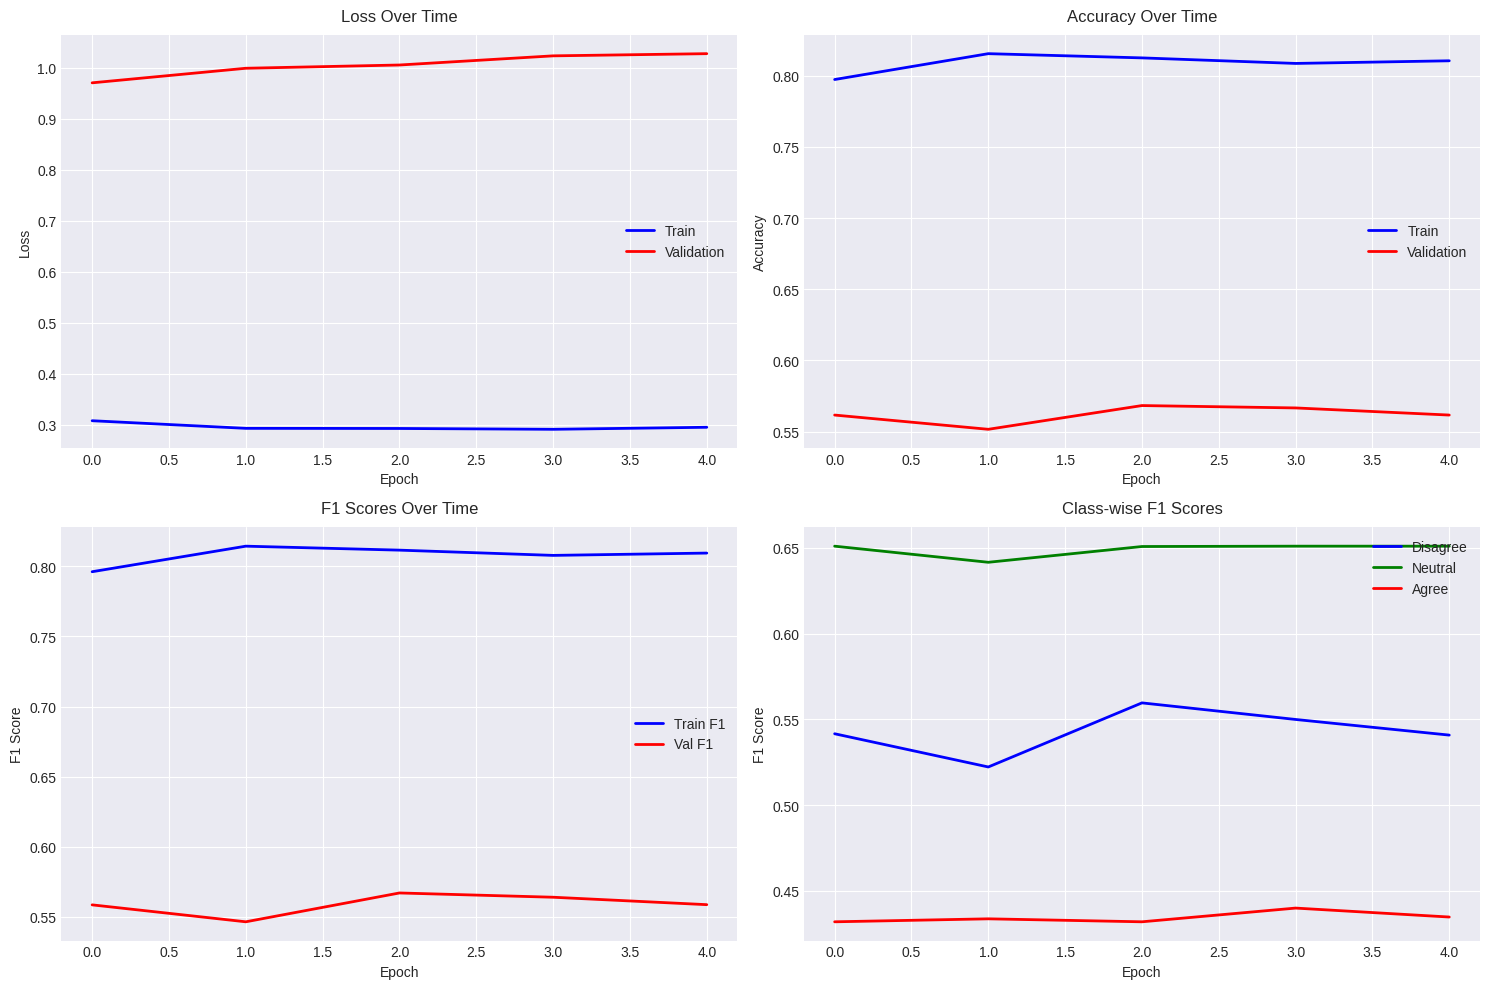

<Figure size 640x480 with 0 Axes>

In [ ]:
# Import seaborn if not already imported
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss Plot
axes[0,0].plot(history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0,0].plot(history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0,0].set_title('Loss Over Time', size=12, pad=10)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Accuracy Plot
axes[0,1].plot(history['train_acc'], 'b-', label='Train', linewidth=2)
axes[0,1].plot(history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[0,1].set_title('Accuracy Over Time', size=12, pad=10)
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True)

# F1 Score Plot
axes[1,0].plot(history['train_f1'], 'b-', label='Train F1', linewidth=2)
axes[1,0].plot(history['val_f1'], 'r-', label='Val F1', linewidth=2)
axes[1,0].set_title('F1 Scores Over Time', size=12, pad=10)
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('F1 Score')
axes[1,0].legend()
axes[1,0].grid(True)

# Class-wise metrics
class_f1s = list(zip(*[(d['Disagree'], d['Neutral'], d['Agree'])
                       for d in history['class_f1_scores']]))
axes[1,1].plot(class_f1s[0], 'b-', label='Disagree', linewidth=2)
axes[1,1].plot(class_f1s[1], 'g-', label='Neutral', linewidth=2)
axes[1,1].plot(class_f1s[2], 'r-', label='Agree', linewidth=2)
axes[1,1].set_title('Class-wise F1 Scores', size=12, pad=10)
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('F1 Score')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Save plots
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

In [ ]:
# Cell 4: Training setup
epochs = 5
best_f1 = 0
patience = 2
patience_counter = 0
early_stop = False

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

# Cell 5: Training Loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    true_labels = []
    pred_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

        # Calculate weighted loss
        loss = F.cross_entropy(logits, labels, weight=class_weights)

        # Backward pass with gradient clipping
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(true_labels, pred_labels)

    # Validation phase
    model.eval()
    val_loss = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)

            # Calculate weighted validation loss
            loss = F.cross_entropy(outputs.logits, labels, weight=class_weights)
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    # Print epoch metrics
    print(f"\nEpoch {epoch + 1} Metrics:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early stopping and model saving
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'tokenizer': tokenizer,
            'f1_score': f1,
            'history': history,
            'class_weights': class_weights,
            'label_map': {0: -1, 1: 0, 2: 1}
        }, 'best_model.pt')
        print("\nSaved new best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            early_stop = True
            break

    if early_stop:
        break




Epoch 1/5


Training:   0%|          | 0/179 [00:00<?, ?it/s]


NameError: name 'F1' is not defined

In [ ]:
# Calculate class weights for imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

# 8. Training Loop
epochs = 5
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=1,
    verbose=True
)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    true_labels = []
    pred_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

        # Calculate weighted loss
        loss = F.cross_entropy(logits, labels, weight=class_weights)

        # Backward pass with gradient clipping
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(true_labels, pred_labels)

    # Validation phase
    model.eval()
    val_loss = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)

            # Calculate weighted validation loss
            loss = F.cross_entropy(outputs.logits, labels, weight=class_weights)
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    # Print epoch metrics
    print(f"\nEpoch {epoch + 1} Metrics:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Save model at each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history,
        'class_weights': class_weights
    }, f'model_epoch_{epoch+1}.pt')
    print(f"\nSaved model for epoch {epoch+1}")

    # Save best model with all necessary components
    if f1 > best_f1:
        best_f1 = f1
        # Save complete model with all necessary information
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'tokenizer': tokenizer,
            'f1_score': f1,
            'history': history,
            'label_map': {0: -1, 1: 0, 2: 1}  # Map back to original labels
        }, 'best_model.pt')
        print("\nSaved new best model!")

# After training completes, save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/bert_agreement_model/'
os.makedirs(save_path, exist_ok=True)
shutil.copy('best_model.pt', save_path + 'best_model.pt')

# 1. Mount Google Drive and set up save location
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/bert_agreement_model/'
os.makedirs(save_path, exist_ok=True)

# 2. Save all epoch models (if you want to keep them all)
for epoch in range(epochs):
    source_path = f'model_epoch_{epoch+1}.pt'
    if os.path.exists(source_path):
        shutil.copy(source_path, save_path + source_path)


NameError: name 'compute_class_weight' is not defined

In [ ]:
# After training completes, run this visualization and saving code

import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import shutil

# 1. Mount Google Drive and set up save location
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/bert_agreement_model/'
os.makedirs(save_path, exist_ok=True)

# 2. Save all epoch models (if you want to keep them all)
for epoch in range(epochs):
    source_path = f'model_epoch_{epoch+1}.pt'
    if os.path.exists(source_path):
        shutil.copy(source_path, save_path + source_path)

# 3. Create and save metrics DataFrame
metrics_df = pd.DataFrame({
    'Epoch': range(1, epochs + 1),
    'Train Loss': history['train_loss'],
    'Train Accuracy': history['train_acc'],
    'Val Loss': history['val_loss'],
    'Val Accuracy': history['val_acc'],
    'Val Precision': history['val_precision'],
    'Val Recall': history['val_recall'],
    'Val F1': history['val_f1']
})

# Save metrics to CSV
metrics_df.to_csv(save_path + 'training_metrics.csv', index=False)
print("\nTraining Metrics Summary:")
print(metrics_df.round(4).to_string(index=False))

# 4. Create visualizations
plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 15))

# Loss Plot
plt.subplot(3, 2, 1)
plt.plot(history['train_loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Loss Over Time', size=14, pad=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(fontsize=12)
plt.grid(True)

# Accuracy Plot
plt.subplot(3, 2, 2)
plt.plot(history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Accuracy Over Time', size=14, pad=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=12)
plt.grid(True)

# Metrics Plot
plt.subplot(3, 2, 3)
plt.plot(history['val_f1'], 'g-', label='F1 Score', linewidth=2)
plt.plot(history['val_precision'], 'b-', label='Precision', linewidth=2)
plt.plot(history['val_recall'], 'r-', label='Recall', linewidth=2)
plt.title('Validation Metrics', size=14, pad=20)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(fontsize=12)
plt.grid(True)

# Confusion Matrix
plt.subplot(3, 2, 4)
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Disagree', 'Neutral', 'Agree'],
            yticklabels=['Disagree', 'Neutral', 'Agree'])
plt.title('Confusion Matrix', size=14, pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Learning Rate Plot (if using scheduler)
plt.subplot(3, 2, 5)
current_lr = optimizer.param_groups[0]['lr']
plt.plot([current_lr] * epochs, 'g-', label='Learning Rate', linewidth=2)
plt.title('Learning Rate', size=14, pad=20)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.savefig(save_path + 'training_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Save detailed classification report
report = classification_report(true_labels, pred_labels,
                             target_names=['Disagree', 'Neutral', 'Agree'],
                             output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(save_path + 'classification_report.csv')

print("\nDetailed Classification Report:")
print(classification_report(true_labels, pred_labels,
                          target_names=['Disagree', 'Neutral', 'Agree']))

# 6. Print summary of saved files
print(f"\nTraining completed! All files saved to: {save_path}")
print("Saved files:")
print("1. model_epoch_X.pt - Models from each epoch")
print("2. training_metrics.csv - Detailed metrics for each epoch")
print("3. training_plots.png - Visualization of training progress")
print("4. classification_report.csv - Detailed classification metrics")

# 7. Create a ZIP file of all saved files (optional)
shutil.make_archive(save_path + 'all_files', 'zip', save_path)
print("5. all_files.zip - Compressed archive of all files")

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Training Loop
# 8. Training Loop
epochs = 5
best_f1 = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    true_labels = []
    pred_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(true_labels, pred_labels)

    # Validation phase
    model.eval()
    val_loss = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    # Print epoch metrics
    print(f"\nEpoch {epoch + 1} Metrics:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_f1,
            'tokenizer': tokenizer,
            'history': history
        }, 'best_model.pt')
        print("\nSaved new best model!")


Epoch 1/5


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 1 Metrics:
Train Loss: 1.0324, Train Accuracy: 0.4512
Val Loss: 0.9801, Val Accuracy: 0.5267
Precision: 0.4880, Recall: 0.5267, F1-Score: 0.4352

Saved new best model!

Epoch 2/5


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 2 Metrics:
Train Loss: 0.9665, Train Accuracy: 0.5368
Val Loss: 0.9342, Val Accuracy: 0.5467
Precision: 0.5206, Recall: 0.5467, F1-Score: 0.4677

Saved new best model!

Epoch 3/5


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]



Epoch 3 Metrics:
Train Loss: 0.8869, Train Accuracy: 0.5933
Val Loss: 0.8883, Val Accuracy: 0.5800
Precision: 0.5797, Recall: 0.5800, F1-Score: 0.5355

Saved new best model!

Epoch 4/5


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]



Epoch 4 Metrics:
Train Loss: 0.7787, Train Accuracy: 0.6558
Val Loss: 0.8518, Val Accuracy: 0.5933
Precision: 0.6079, Recall: 0.5933, F1-Score: 0.5538

Saved new best model!

Epoch 5/5


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]



Epoch 5 Metrics:
Train Loss: 0.6132, Train Accuracy: 0.7523
Val Loss: 0.9381, Val Accuracy: 0.6533
Precision: 0.6338, Recall: 0.6533, F1-Score: 0.6249

Saved new best model!


In [ ]:
# This code did not worked really !!!
# so move on to the next code !!!

'''
import shutil
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as plt
print(plt.style.available)


# 9. Save model and metrics to Google Drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/bert_agreement_model/'
os.makedirs(save_path, exist_ok=True)
shutil.copy('best_model.pt', save_path + 'best_model.pt')

# 10. Create final metrics table
metrics_df = pd.DataFrame({
    'Epoch': range(1, epochs + 1),
    'Train Loss': history['train_loss'],
    'Train Accuracy': history['train_acc'],
    'Val Loss': history['val_loss'],
    'Val Accuracy': history['val_acc'],
    'Val Precision': history['val_precision'],
    'Val Recall': history['val_recall'],
    'Val F1': history['val_f1']
})

# Save metrics to CSV
metrics_df.to_csv(save_path + 'training_metrics.csv', index=False)
print("\nTraining Metrics Summary:")
print(metrics_df.round(4).to_string(index=False))

# 11. Visualization
plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 10))


# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Loss Over Time', size=12)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)

# Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Accuracy Over Time', size=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)

# Metrics Plot
plt.subplot(2, 2, 3)
plt.plot(history['val_f1'], 'g-', label='F1 Score', linewidth=2)
plt.plot(history['val_precision'], 'b-', label='Precision', linewidth=2)
plt.plot(history['val_recall'], 'r-', label='Recall', linewidth=2)
plt.title('Validation Metrics', size=12)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(fontsize=10)
plt.grid(True)

# Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Disagree', 'Neutral', 'Agree'],
            yticklabels=['Disagree', 'Neutral', 'Agree'])
plt.title('Confusion Matrix', size=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(save_path + 'training_plots.png')
plt.show()

# 12. Print final classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, pred_labels,
                          target_names=['Disagree', 'Neutral', 'Agree']))

print(f"\nTraining completed! All files saved to: {save_path}")
print("Saved files:")
print("1. best_model.pt - The trained model")
print("2. training_metrics.csv - Detailed metrics for each epoch")
print("3. training_plots.png - Visualization of training progress")

'''

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training Metrics Summary:
 Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy  Val Precision  Val Recall  Val F1
     1      1.0324          0.4512    0.9801        0.5267         0.4880      0.5267  0.4352
     2      0.9665          0.5368    0.9342        0.5467         0.5206      0.5467  0.4677
 

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Available Matplotlib styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training Metrics Summary:
 Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy  Val Precision  Val Recall  Val F1
     1      1.0324          0.4512    0.9801        0.5267         0.4880      0.5267  0.4352
     2      0.9665          0.5368    0.9342        0.5467        

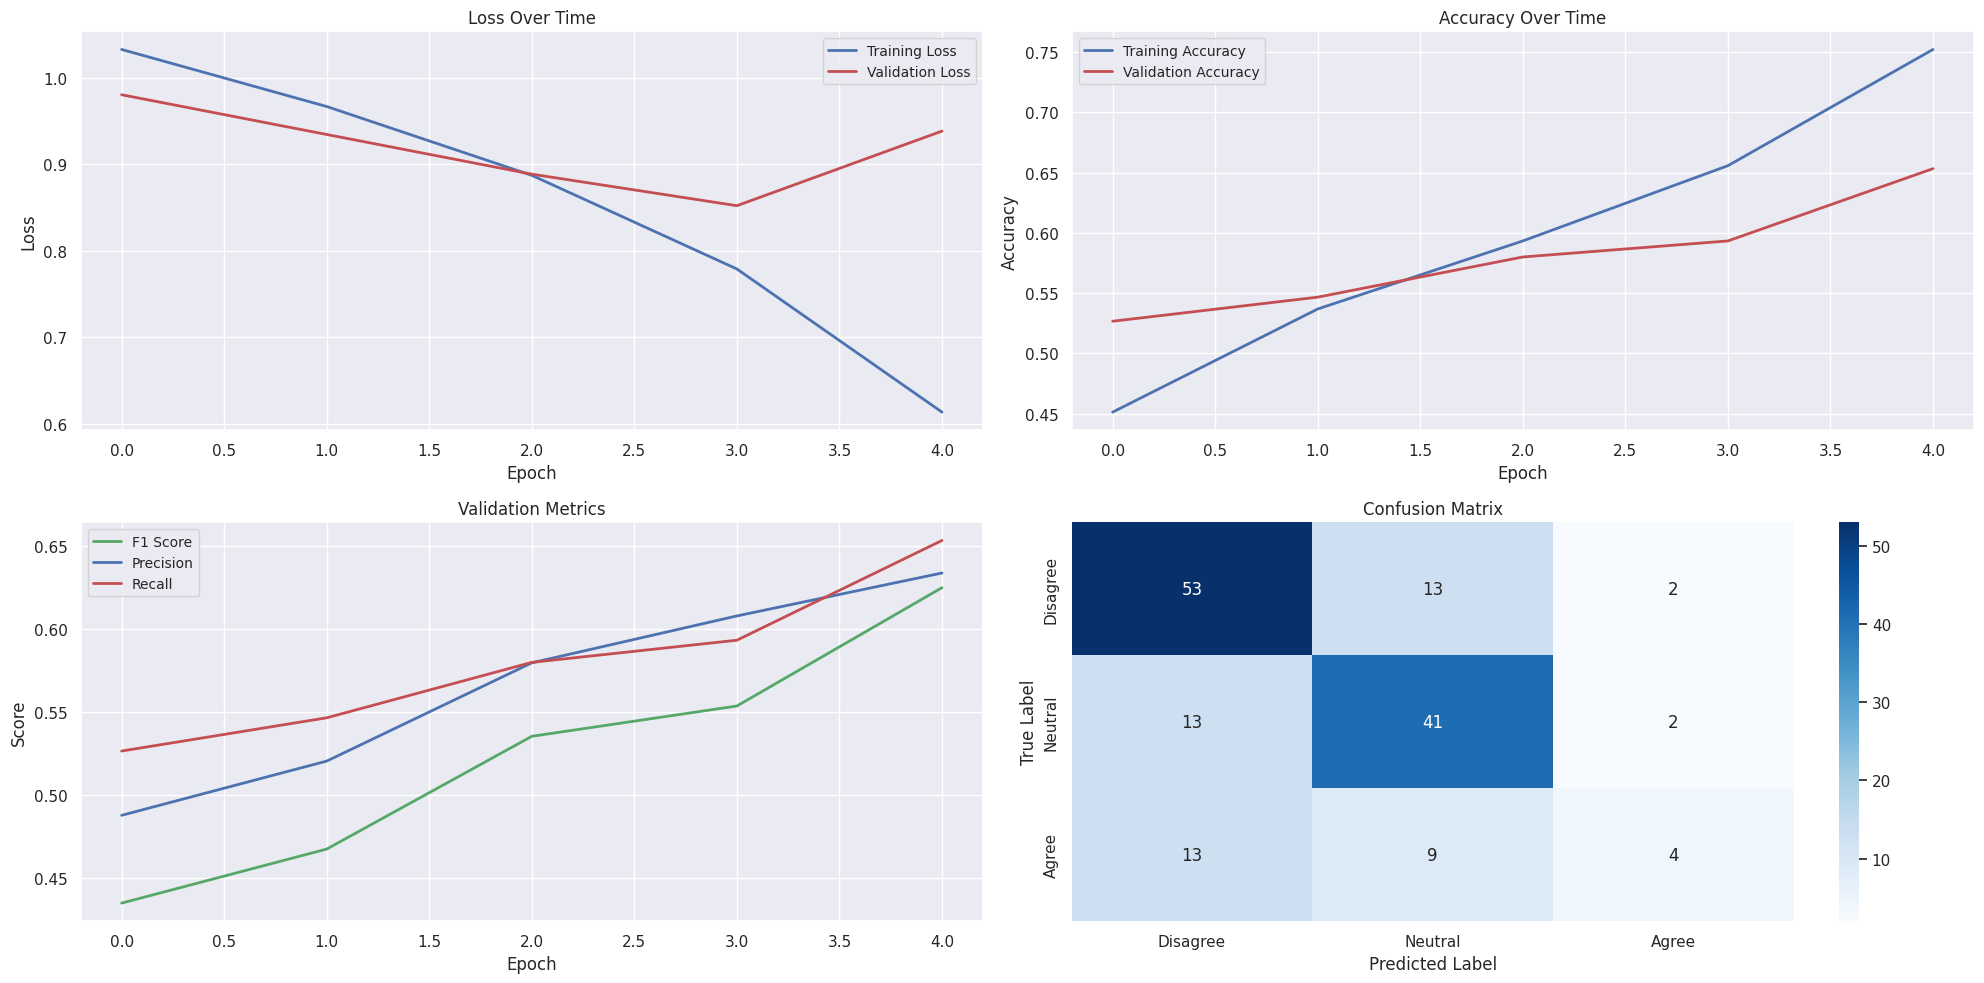


Detailed Classification Report:
              precision    recall  f1-score   support

    Disagree       0.67      0.78      0.72        68
     Neutral       0.65      0.73      0.69        56
       Agree       0.50      0.15      0.24        26

    accuracy                           0.65       150
   macro avg       0.61      0.56      0.55       150
weighted avg       0.63      0.65      0.62       150


Training completed! All files saved to: /content/drive/MyDrive/bert_agreement_model/
Saved files:
1. best_model.pt - The trained model
2. training_metrics.csv - Detailed metrics for each epoch
3. training_plots.png - Visualization of training progress


In [ ]:
import shutil
#!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd  # Ensure pandas is imported
from sklearn.metrics import confusion_matrix, classification_report  # For confusion matrix and report

# Display available Matplotlib styles
print("Available Matplotlib styles:", plt.style.available)

# 9. Save model and metrics to Google Drive
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/bert_agreement_model/'
os.makedirs(save_path, exist_ok=True)
shutil.copy('best_model.pt', save_path + 'best_model.pt')

# Assuming `epochs` and `history` variables are defined
# 10. Create final metrics table
metrics_df = pd.DataFrame({
    'Epoch': range(1, epochs + 1),
    'Train Loss': history['train_loss'],
    'Train Accuracy': history['train_acc'],
    'Val Loss': history['val_loss'],
    'Val Accuracy': history['val_acc'],
    'Val Precision': history['val_precision'],
    'Val Recall': history['val_recall'],
    'Val F1': history['val_f1']
})

# Save metrics to CSV
metrics_df.to_csv(save_path + 'training_metrics.csv', index=False)
print("\nTraining Metrics Summary:")
print(metrics_df.round(4).to_string(index=False))

# 11. Visualization
sns.set(style='darkgrid')  # Use Seaborn's dark grid style for plots
fig = plt.figure(figsize=(20, 10))

# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Loss Over Time', size=12)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)

# Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Accuracy Over Time', size=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)

# Metrics Plot
plt.subplot(2, 2, 3)
plt.plot(history['val_f1'], 'g-', label='F1 Score', linewidth=2)
plt.plot(history['val_precision'], 'b-', label='Precision', linewidth=2)
plt.plot(history['val_recall'], 'r-', label='Recall', linewidth=2)
plt.title('Validation Metrics', size=12)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(fontsize=10)
plt.grid(True)

# Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Disagree', 'Neutral', 'Agree'],
            yticklabels=['Disagree', 'Neutral', 'Agree'])
plt.title('Confusion Matrix', size=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(save_path + 'training_plots.png')
plt.show()

# 12. Print final classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, pred_labels,
                            target_names=['Disagree', 'Neutral', 'Agree']))

print(f"\nTraining completed! All files saved to: {save_path}")
print("Saved files:")
print("1. best_model.pt - The trained model")
print("2. training_metrics.csv - Detailed metrics for each epoch")
print("3. training_plots.png - Visualization of training progress")


# **old codes**

In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

# 2. GPU Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 3. Load Dataset
!gdown "https://drive.google.com/uc?id=1WLCQaebbW4B--gTZig6E3-JS7x_moqTl"

print("\n=== Loading Dataset ===")
data = pd.read_csv('labeled_sample_data_correct.csv')
print(f"Dataset size: {len(data)} rows")

# 4. Check for NaN values
print("\nChecking for NaN values:")
print(data.isnull().sum())

# 5. Prepare Data
posts = data['cleaned_text'].tolist()
comments = data['cleaned_body'].tolist()
labels = data['label_agreement'].map({-1: 0, 0: 1, 1: 2}).tolist()

# Print label distribution
label_dist = pd.Series(labels).value_counts()
print("\nLabel distribution:")
print(label_dist)

# 6. Initialize Tokenizer
print("\n=== Initializing Tokenizer ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 7. Smart Tokenization Function
def smart_truncate_and_tokenize(posts, comments, max_length=512):
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3

    truncated_pairs = []
    for post, comment in zip(posts, comments):
        post_tokens = tokenizer.encode(
            post,
            add_special_tokens=False,
            truncation=True,
            max_length=post_max_length
        )

        comment_tokens = tokenizer.encode(
            comment,
            add_special_tokens=False,
            truncation=True,
            max_length=comment_max_length
        )

        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        truncated_pairs.append(combined_tokens)

    padded_pairs = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in truncated_pairs],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    attention_masks = (padded_pairs != tokenizer.pad_token_id).long()

    return {
        'input_ids': padded_pairs,
        'attention_mask': attention_masks
    }

# 8. Split and Tokenize Dataset
print("\n=== Splitting Dataset ===")
train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    posts, comments, labels, test_size=0.05, random_state=42, stratify=labels
)
print(f"Training set size: {len(train_posts)}")
print(f"Validation set size: {len(val_posts)}")

# Tokenize data
print("\n=== Tokenizing Data ===")
train_tokens = smart_truncate_and_tokenize(train_posts, train_comments)
val_tokens = smart_truncate_and_tokenize(val_posts, val_comments)

# Add labels to token dictionaries
train_tokens['labels'] = torch.tensor(train_labels, dtype=torch.long)
val_tokens['labels'] = torch.tensor(val_labels, dtype=torch.long)

# 9. Dataset Class
class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['labels'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.tokens.items()}

# Create datasets
train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)

# 10. Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# 11. Initialize and Freeze BERT
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

# Freeze the lower layers of BERT
for param in model.bert.embeddings.parameters():
    param.requires_grad = False  # Freeze the embedding layer
for layer in model.bert.encoder.layer[:6]:  # Freeze the first 6 layers
    for param in layer.parameters():
        param.requires_grad = False

print("\nFrozen the first 6 layers of BERT")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params:,}")

# Move model to GPU
model.to(device)

# 12. Set up optimizer
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)

print("\nSetup completed!")

Using device: cuda
Downloading...
From: https://drive.google.com/uc?id=1WLCQaebbW4B--gTZig6E3-JS7x_moqTl
To: /content/labeled_sample_data_correct.csv
100% 32.0M/32.0M [00:00<00:00, 152MB/s]

=== Loading Dataset ===
Dataset size: 3000 rows

Checking for NaN values:
level_0                       0
index                         0
post_id                       0
link_id                       0
subreddit                     0
parent_id                     0
redditor_id                   0
created_at                    0
body                          0
score                         0
edited                        0
parent_id_clean               0
has_delta                     0
title                         0
text                          0
permalink                     0
post_id_parent                1
redditor_id_parent            1
body_clean                    0
knowledge_mean                0
knowledge_max                 0
knowledge_min                 0
knowledge_std                 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Frozen the first 6 layers of BERT
Number of trainable parameters: 43,120,131

Setup completed!


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import tensorflow as tf
# Check if a GPU is available.
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 27 13:21:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import warnings
#warnings.filterwarnings("ignore")

# Memory cleanup and optimization
import gc



# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# url= https://drive.google.com/file/d/1WLCQaebbW4B--gTZig6E3-JS7x_moqTl/view?usp=sharing  # the correct url of dataset  in my google drive is this one


# Load dataset
print("\n=== Loading Dataset ===")
!gdown "https://drive.google.com/uc?id=1WLCQaebbW4B--gTZig6E3-JS7x_moqTl" # the correct dataset is this one
#!gdown "https://drive.google.com/uc?id=10E9RV2p0XREskcaDeJMvQ430tgGDgq1Z"
data = pd.read_csv('labeled_sample_data_correct.csv')
print(f"Dataset size: {len(data)} rows")

# Check for NaN values
print("\nChecking for NaN values:")
print(data.isnull().sum())

# Remove rows with NaN values
#data = data.dropna(subset=['cleaned_text', 'cleaned_body', 'label_agreement'])
#print(f"\nDataset size after removing NaN: {len(data)} rows")

# Prepare data
posts = data['cleaned_text'].tolist()
comments = data['cleaned_body'].tolist()
labels = data['label_agreement'].map({-1: 0, 0: 1, 1: 2}).tolist()

# Print label distribution
label_dist = pd.Series(labels).value_counts()
print("\nLabel distribution:")
print(label_dist)


# Initialize tokenizer
print("\n=== Initializing Tokenizer ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Analyze token lengths
print("\n=== Analyzing Token Lengths ===")
post_lengths = []
comment_lengths = []
combined_lengths = []


'''
# Sample 5 random pairs for detailed analysis
print("\nDetailed analysis of 5 random samples:")
np.random.seed(42)  # for reproducibility
for i in np.random.randint(0, len(posts), 5):
    # Tokenize post
    post_tokens = tokenizer.encode(posts[i], add_special_tokens=True)
    post_lengths.append(len(post_tokens))

    # Tokenize comment
    comment_tokens = tokenizer.encode(comments[i], add_special_tokens=True)
    comment_lengths.append(len(comment_tokens))

    # Tokenize combined
    combined = f"{posts[i]} [SEP] {comments[i]}"
    combined_tokens = tokenizer.encode(combined, add_special_tokens=True)
    combined_lengths.append(len(combined_tokens))

    print(f"\nSample {i}:")
    print(f"Post length: {len(post_tokens)} tokens")
    print(f"Comment length: {len(comment_tokens)} tokens")
    print(f"Combined length: {len(combined_tokens)} tokens")
    print(f"Label: {labels[i]}")

print("\nToken length statistics:")
print(f"Average post length: {np.mean(post_lengths):.1f} tokens")
print(f"Average comment length: {np.mean(comment_lengths):.1f} tokens")
print(f"Average combined length: {np.mean(combined_lengths):.1f} tokens")
'''



Using device: cuda

=== Loading Dataset ===
Downloading...
From: https://drive.google.com/uc?id=1WLCQaebbW4B--gTZig6E3-JS7x_moqTl
To: /content/labeled_sample_data_correct.csv
100% 32.0M/32.0M [00:00<00:00, 226MB/s]
Dataset size: 3000 rows

Checking for NaN values:
level_0                       0
index                         0
post_id                       0
link_id                       0
subreddit                     0
parent_id                     0
redditor_id                   0
created_at                    0
body                          0
score                         0
edited                        0
parent_id_clean               0
has_delta                     0
title                         0
text                          0
permalink                     0
post_id_parent                1
redditor_id_parent            1
body_clean                    0
knowledge_mean                0
knowledge_max                 0
knowledge_min                 0
knowledge_std                 0

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


=== Analyzing Token Lengths ===


'\n# Sample 5 random pairs for detailed analysis\nprint("\nDetailed analysis of 5 random samples:")\nnp.random.seed(42)  # for reproducibility\nfor i in np.random.randint(0, len(posts), 5):\n    # Tokenize post\n    post_tokens = tokenizer.encode(posts[i], add_special_tokens=True)\n    post_lengths.append(len(post_tokens))\n\n    # Tokenize comment\n    comment_tokens = tokenizer.encode(comments[i], add_special_tokens=True)\n    comment_lengths.append(len(comment_tokens))\n\n    # Tokenize combined\n    combined = f"{posts[i]} [SEP] {comments[i]}"\n    combined_tokens = tokenizer.encode(combined, add_special_tokens=True)\n    combined_lengths.append(len(combined_tokens))\n\n    print(f"\nSample {i}:")\n    print(f"Post length: {len(post_tokens)} tokens")\n    print(f"Comment length: {len(comment_tokens)} tokens")\n    print(f"Combined length: {len(combined_tokens)} tokens")\n    print(f"Label: {labels[i]}")\n\nprint("\nToken length statistics:")\nprint(f"Average post length: {np.mean(p

In [ ]:
# Smart tokenization function
def smart_truncate_and_tokenize(posts, comments, max_length=512):
    """
    Smartly truncates and tokenizes posts and comments with more tokens allocated to posts

    Args:
        posts: List of post texts
        comments: List of comment texts
        max_length: Maximum sequence length

    Returns:
        tokens: Dictionary containing input_ids, attention_mask, and other tokenizer outputs
    """
    # Allocate more tokens to posts (70-30 split)
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3  # Account for special tokens

    truncated_pairs = []
    for post, comment in zip(posts, comments):
        # Tokenize post and comment separately
        post_tokens = tokenizer.encode(
            post,
            add_special_tokens=False,
            truncation=True,
            max_length=post_max_length
        )

        comment_tokens = tokenizer.encode(
            comment,
            add_special_tokens=False,
            truncation=True,
            max_length=comment_max_length
        )

        # Combine with special tokens
        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        truncated_pairs.append(combined_tokens)

    # Pad sequences
    padded_pairs = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in truncated_pairs],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    # Create attention masks
    attention_masks = (padded_pairs != tokenizer.pad_token_id).long()

    return {
        'input_ids': padded_pairs,
        'attention_mask': attention_masks
    }


In [ ]:
# just for test how it works and for debugging


'''
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def smart_truncate_and_tokenize_with_logging(posts, comments, max_length=512):
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3  # Special tokens
    truncated_pairs = []

    for i, (post, comment) in enumerate(zip(posts, comments)):
        post_tokens = tokenizer.encode(post, add_special_tokens=False, truncation=True, max_length=post_max_length)
        comment_tokens = tokenizer.encode(comment, add_special_tokens=False, truncation=True, max_length=comment_max_length)
        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        truncated_pairs.append(combined_tokens)

        logger.info(f"Sample {i}: Post Tokens = {len(post_tokens)}, Comment Tokens = {len(comment_tokens)}, Combined = {len(combined_tokens)}")

    padded_pairs = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in truncated_pairs],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    attention_masks = (padded_pairs != tokenizer.pad_token_id).long()

    return {
        'input_ids': padded_pairs,
        'attention_mask': attention_masks
    }
'''

In [ ]:
# testing the dataset with the Example data as below:

# Example data
postsamp = [
    "This is a very long example post that exceeds the token limit.",
    "Another example of a post with more content.",
    "the this post can be to long and stupid, but i like to add this scientific things here to mention that some idea can be practical however silly and opinion changing."
]
commentsamp = [
    "This is a short comment. for these exceed tokens we need to add some steps.",
    "Another short commentshows that better content is the long ones.",
    "I do not belive it at all becuase when i was young I though similar, but know i beleve stupid is stupid."
]
labelsamp = [1, 2, 0]  # Ensure at least 2 samples per class

# Test the function smart_truncate_and_tokenize_with_logging
tokens = smart_truncate_and_tokenize(postsamp, commentsamp)

# Inspect tokenized results 1
print("Input IDs:", tokens['input_ids'])
print("Attention Masks:", tokens['attention_mask'])
print("---------------------------------------------------------------")
# print both sentences reuslt of tokenizing for 3

print("Input IDs:", tokens['input_ids'][0].tolist(), tokens['input_ids'][1].tolist(), tokens['input_ids'][2].tolist())
print("Attention Masks:", tokens['attention_mask'][0].tolist(), tokens['attention_mask'][1].tolist(), tokens['attention_mask'][2].tolist())
print("---------------------------------------------------------------")
# Decode a sample
decoded_text_1 = tokenizer.decode(tokens['input_ids'][0].tolist(), skip_special_tokens=False)
print("Decoded Tokens (Sample 1):", decoded_text_1)
print("******************************************************")

decoded_text_2= tokenizer.decode(tokens['input_ids'][1].tolist(), skip_special_tokens=False)
print("Decoded Tokens (Sample 2):", decoded_text_2)
print("******************************************************")
decoded_text_3= tokenizer.decode(tokens['input_ids'][2].tolist(), skip_special_tokens=False)
print("Decoded Tokens (Sample 3):", decoded_text_3)
# Test the function smart_truncate_and_tokenize
#tokens = smart_truncate_and_tokenize(postsamp, comments)

# Inspect tokenized results
#print("Input IDs:", tokens['input_ids'])
#print("Attention Masks:", tokens['attention_mask'])

# Decode a sample
#decoded_text = tokenizer.decode(tokens['input_ids'][0].tolist(), skip_special_tokens=False)
#print("Decoded Tokens (Sample 1):", decoded_text)

Input IDs: tensor([[  101,  2023,  2003,  1037,  2200,  2146,  2742,  2695,  2008, 23651,
          1996, 19204,  5787,  1012,   102,  2023,  2003,  1037,  2460,  7615,
          1012,  2005,  2122, 13467, 19204,  2015,  2057,  2342,  2000,  5587,
          2070,  4084,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2178,  2742,  1997,  1037,  2695,  2007,  2062,  4180,  1012,
           102,  2178,  2460,  7928, 14406,  2015,  2008,  2488,  4180,  2003,
          1996,  2146,  3924,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [ ]:
# Verify lengths
print(f"Length of posts: {len(posts)}")
print(f"Length of comments: {len(comments)}")
print(f"Length of labels: {len(labels)}")

Length of posts: 3000
Length of comments: 3000
Length of labels: 3000


In [ ]:
# Split dataset
print("\n=== Splitting Dataset ===")
train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    posts, comments, labels, test_size=0.05, random_state=42, stratify=labels  # Stratify ensures balanced label distribution
)
print(f"Training set size: {len(train_posts)}")
print(f"Validation set size: {len(val_posts)}")

# Tokenize data
print("\n=== Tokenizing Data ===")
train_tokens = smart_truncate_and_tokenize(train_posts, train_comments)
val_tokens = smart_truncate_and_tokenize(val_posts, val_comments)
print("####################################33")
print(train_tokens['input_ids'].shape)
print("####################################33")
print(train_tokens['attention_mask'].shape)
print("####################################33")
print(train_tokens['input_ids'][0].shape)
print("####################################33")
print(train_tokens['attention_mask'][0].shape)
print("####################################33")
print(train_tokens['input_ids'][0])
print("####################################33")
print(train_tokens['attention_mask'][0])
print("####################################33")
print(train_tokens['input_ids'][0].tolist())
print("####################################33")
print(train_tokens['attention_mask'][0].tolist())
print("####################################33")
print(train_tokens['input_ids'][1].tolist())
print("####################################33")
print(train_tokens['attention_mask'][1].tolist())
print("####################################33")
print(train_tokens['input_ids'][2].tolist())
print("####################################33")
print(train_tokens['attention_mask'][2].tolist())
print("####################################33")


# Add labels to token dictionaries
train_tokens['labels'] = torch.tensor(train_labels, dtype=torch.long)  # Ensure labels are of type `torch.long`
val_tokens['labels'] = torch.tensor(val_labels, dtype=torch.long)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(train_tokens['labels'])
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(val_tokens['labels'])
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

# Dataset class
class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['labels'])  # Length is based on the number of labels

    def __getitem__(self, idx):
        # Return a dictionary of input_ids, attention_mask, and labels for the given index
        return {key: val[idx] for key, val in self.tokens.items()}

# Create datasets
train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(train_dataset[0])
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(val_dataset[0])
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(train_dataset[1])
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(val_dataset[1])
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")


# Print example from the dataset
print("\n=== Example from Training Dataset 000000000 ===")
example = train_dataset[0]
for key, value in example.items():
    print(f"{key}: {value}")
    print("_______________________________________________________")

print("\n=== Example from Validation Dataset 11111111111 ===")
example = val_dataset[1]
for key, value in example.items():
    print(f"{key}: {value}")
    print("_______________________________________________________")



=== Splitting Dataset ===
Training set size: 2850
Validation set size: 150

=== Tokenizing Data ===
####################################33
torch.Size([2850, 512])
####################################33
torch.Size([2850, 512])
####################################33
torch.Size([512])
####################################33
torch.Size([512])
####################################33
tensor([  101, 10086,  1024,  4067,  2017,  2035,  1010,  2008,  2001,  4569,
         1012,  1045,  2001,  3308,  2055,  2300,  1010,  1020,  1003,  1997,
         1996,  2300,  4425,  1999,  1996,  2866,  2003,  2109,  2006,  7125,
         1012,  3438,  1003,  1997,  1996,  2300,  2109,  2011, 17188,  3310,
         2013,  1996,  4968,  4425,  2738,  2084, 24504,  1012,  1045,  2001,
         3308,  2055,  2833,  1012,  2382,  1003,  1997,  1037, 17188, 13822,
         2003,  2013,  8982,  1010,  2029,  2003,  2184,  1003,  1997,  1996,
         2866,  2015, 11203,  1045,  2001, 14603,  2000,  4553,  2008,  19

In [ ]:
print(f"Length of input_ids: {len(example['input_ids'])}")
print(f"Length of attention_mask: {len(example['attention_mask'])}")
assert len(example['input_ids']) == len(example['attention_mask']), "Mismatch in lengths!"
print("_______________________________________________________")

decoded_text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
print(f"Decoded Text: {decoded_text}")
print("_______________________________________________________")

from collections import Counter

print("Training Label Distribution:", Counter(train_labels))
print("Validation Label Distribution:", Counter(val_labels))



Length of input_ids: 512
Length of attention_mask: 512
_______________________________________________________
Decoded Text: basically, i believe almost all people are acting in a net harmful way to the future of the community ( whether that be your local community or humanity as a whole ), except those who through their jobs or in another way serve the common good. i have the following premises : we have so advanced technology and relative freedom in the western world now that everyone is having the possibility of much larger externalities on the world, both negative and positive than ever before. in other words, people have the choice to do harm or good. regardless of all positive externalities, the world is in grave danger of becoming significantly worse because of these negative externalities. examples include ( no particular order ) : - slow extinction of liberal democracies - socially harmful media winning over socially beneficial ones - anti - intellectualism and stupidity winni

In [ ]:
print(f"Padding Token ID: {tokenizer.pad_token_id}")
print(f"Padding in Input IDs: {example['input_ids'][-10:]}")  # Last 10 tokens


Padding Token ID: 0
Padding in Input IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# 1. Check data split proportions
print("\n=== Checking Data Split ===")
print(f"Total samples: {len(posts)}")
print(f"Training samples: {len(train_posts)} ({len(train_posts)/len(posts)*100:.1f}%)")
print(f"Validation samples: {len(val_posts)} ({len(val_posts)/len(posts)*100:.1f}%)")

# 2. Check label distribution
print("\n=== Checking Label Distribution ===")
from collections import Counter
print("Original labels:", Counter(labels))
print("Training labels:", Counter(train_labels))
print("Validation labels:", Counter(val_labels))




# 3. Check tokenization
print("\n=== Checking Tokenization ===")
# Check first example
example = train_dataset[0]
print("Token counts:")
print(f"Input IDs length: {len(example['input_ids'])}")
print(f"Attention mask length: {len(example['attention_mask'])}")
print(f"Number of actual tokens (non-padding): {sum(example['attention_mask'])}")

# 4. Decode an example to verify text
print("\n=== Checking Token Decoding ===")
decoded_text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
print(f"Original post: {train_posts[0][:100]}...")
print(f"Decoded text: {decoded_text[:100]}...")



# 5. Check tensor shapes
print("\n=== Checking Tensor Shapes ===")
for key, value in example.items():
    print(f"{key}: {value.shape}")




=== Checking Data Split ===
Total samples: 3000
Training samples: 2850 (95.0%)
Validation samples: 150 (5.0%)

=== Checking Label Distribution ===
Original labels: Counter({0: 1353, 1: 1118, 2: 529})
Training labels: Counter({0: 1285, 1: 1062, 2: 503})
Validation labels: Counter({0: 68, 1: 56, 2: 26})

=== Checking Tokenization ===
Token counts:
Input IDs length: 512
Attention mask length: 512
Number of actual tokens (non-padding): 476

=== Checking Token Decoding ===
Original post: edit: thank you all, that was fun. i was wrong about water, 6% of the water supply in the uk is used...
Decoded text: edit : thank you all, that was fun. i was wrong about water, 6 % of the water supply in the uk is us...

=== Checking Tensor Shapes ===
input_ids: torch.Size([512])
attention_mask: torch.Size([512])
labels: torch.Size([])


In [ ]:
### testing


'''
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

postsamp = [
    "This is a very long example post that exceeds the token limit.",
    "Another example of a post with more content.",
    "A third example post.",
    "A fourth example post with different content."
]
commentsamp = [
    "This is a short comment.",
    "Another short comment.",
    "A third short comment.",
    "A fourth short comment."
]
labelsamp = [0, 1, 0, 1]  # Ensure at least 2 samples per class

train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    postsamp, commentsamp, labelsamp, test_size=0.5, random_state=42, stratify=labelsamp
)


# Split dataset
print("\n=== Splitting Dataset ===")
train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    postsamp, commentsamp, labelsamp, test_size=0.5, random_state=42, stratify=labelsamp
)
print(f"Training set size: {len(train_posts)}")
print(f"Validation set size: {len(val_posts)}")

# Tokenize data
print("\n=== Tokenizing Data ===")
train_tokens = smart_truncate_and_tokenize(train_posts, train_comments)
val_tokens = smart_truncate_and_tokenize(val_posts, val_comments)

# Add labels to token dictionaries
train_tokens['labels'] = torch.tensor(train_labels, dtype=torch.long)
val_tokens['labels'] = torch.tensor(val_labels, dtype=torch.long)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['labels'])  # Length is based on the number of labels

    def __getitem__(self, idx):
        # Return a dictionary of input_ids, attention_mask, and labels for the given index
        return {key: val[idx] for key, val in self.tokens.items()}

# Create datasets
train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)

# Print example from the dataset
print("\n=== Example from Training Dataset ===")
if len(train_dataset) > 0:
    example = train_dataset[0]
    for key, value in example.items():
        print(f"{key}: {value}")

print("\n=== Example from Validation Dataset ===")
if len(val_dataset) > 0:
    example = val_dataset[0]
    for key, value in example.items():
        print(f"{key}: {value}")
'''


=== Splitting Dataset ===
Training set size: 2
Validation set size: 2

=== Tokenizing Data ===

=== Example from Training Dataset ===
input_ids: tensor([  101,  2023,  2003,  2241,  2006,  2417, 23194,  1998,  2591,  2865,
         1010,  3151,  2865,  1010,  1998,  3331,  2000,  2111,  1006,  2036,
         2672,  1037,  4512,  2007,  2619,  2073,  2009,  3849,  2066,  2027,
         2081,  1037,  2204,  2391,  1006,  2023,  2391,  1007,  1998,  1045,
         2134,  2102,  2031,  2204,  4675,  9918,  2870,  1007,  1012,  1012,
        10468,  7188,  2619,  2013,  1037,  6964,  2417,  2110,  7566,  2055,
        11210,  2027,  2444,  1010,  2027,  2123,  2102, 17612,  2066,  2111,
         2013,  2630,  2163,  2079,  1012,  2009,  3849,  2066,  2065,  2017,
         2024,  1037,  7672,  2542,  1999,  1037,  7672,  2103,  1999,  1037,
         2417,  2110,  1998,  2031,  1037,  7672,  2005,  2343,  1010,  2059,
         2017,  2097,  2022,  3407,  1012,  2471,  2035, 13350,  2006,  25

In [ ]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    drop_last=False
)

# Print dataloader sizes
print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Check batch structure
print("\n=== Checking Batch Structure ===")
train_batch = next(iter(train_loader))
for key, value in train_batch.items():
    print(f"{key} shape: {value.shape}")

# Check actual values in a batch
print("\n=== Sample Batch Contents ===")
print(f"Batch size: {train_batch['input_ids'].size(0)}")
print(f"Sequence length: {train_batch['input_ids'].size(1)}")
print(f"Number of labels in batch: {len(train_batch['labels'])}")
print(f"Labels in this batch: {train_batch['labels'].tolist()}")





Number of training batches: 356
Number of validation batches: 19

=== Checking Batch Structure ===
input_ids shape: torch.Size([8, 512])
attention_mask shape: torch.Size([8, 512])
labels shape: torch.Size([8])

=== Sample Batch Contents ===
Batch size: 8
Sequence length: 512
Number of labels in batch: 8
Labels in this batch: [1, 0, 1, 0, 1, 1, 1, 0]


In [ ]:
scaler = torch.cuda.amp.GradScaler()

<ipython-input-19-a07aef3d7a4b>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Memory cleanup and optimization
import gc
import torch

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Reset GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")



GPU memory available: 15.84 GB


In [ ]:
# Reduce batch size


'''
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Reduced to 4
    shuffle=True,
    pin_memory=True,
    num_workers=1,  # Reduced workers
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,  # Reduced to 4
    shuffle=False,
    pin_memory=True,
    num_workers=1,  # Reduced workers
    drop_last=False
)

'''


In [ ]:
# Initialize model with gradient checkpointing
print("\n=== Initializing Model ===")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    gradient_checkpointing=True
)

# Print model architecture before freezing
print("\n=== Original Model Architecture ===")
for name, param in model.named_parameters():
    print(f"Layer: {name}, Size: {param.size()}, Requires grad: {param.requires_grad}")



=== Initializing Model ===


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Original Model Architecture ===
Layer: bert.embeddings.word_embeddings.weight, Size: torch.Size([30522, 768]), Requires grad: True
Layer: bert.embeddings.position_embeddings.weight, Size: torch.Size([512, 768]), Requires grad: True
Layer: bert.embeddings.token_type_embeddings.weight, Size: torch.Size([2, 768]), Requires grad: True
Layer: bert.embeddings.LayerNorm.weight, Size: torch.Size([768]), Requires grad: True
Layer: bert.embeddings.LayerNorm.bias, Size: torch.Size([768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.query.weight, Size: torch.Size([768, 768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.query.bias, Size: torch.Size([768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.key.weight, Size: torch.Size([768, 768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.key.bias, Size: torch.Size([768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.value.weight, Size: torch.Size([768, 76

In [ ]:

# Freezing layers

'''
def freeze_layers(model, num_frozen_layers=0):
    print("\n=== Applying Freezing Strategy ===")
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False
    for i in range(num_frozen_layers):
        for param in model.bert.encoder.layer[i].parameters():
            param.requires_grad = False
    for param in model.bert.pooler.parameters():  # Optional
        param.requires_grad = False
    print(f"Embeddings, pooler, and first {num_frozen_layers} layers frozen")

    # Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params / total_params * 100:.1f}%)")
'''

# Freezing layers
def freeze_layers(model, num_frozen_layers):
    print("\n=== Applying Freezing Strategy ===")
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    for layer in model.bert.encoder.layer[:num_frozen_layers]:  # Freeze the first n layers
      for param in layer.parameters():
            param.requires_grad = False

print("\n=== Applying Freezing Strategy ===")
num_frozen_layers = 6

# Apply freezing
freeze_layers(model, num_frozen_layers)








freeze_layers(model)

# Move to device
model = model.to(device)

# Optimizer for trainable parameters
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5,
    weight_decay=0.01
)

# Print trainable layers for validation
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Layer: {name}")



=== Applying Freezing Strategy ===

=== Applying Freezing Strategy ===
Trainable Layer: bert.encoder.layer.6.attention.self.query.weight
Trainable Layer: bert.encoder.layer.6.attention.self.query.bias
Trainable Layer: bert.encoder.layer.6.attention.self.key.weight
Trainable Layer: bert.encoder.layer.6.attention.self.key.bias
Trainable Layer: bert.encoder.layer.6.attention.self.value.weight
Trainable Layer: bert.encoder.layer.6.attention.self.value.bias
Trainable Layer: bert.encoder.layer.6.attention.output.dense.weight
Trainable Layer: bert.encoder.layer.6.attention.output.dense.bias
Trainable Layer: bert.encoder.layer.6.attention.output.LayerNorm.weight
Trainable Layer: bert.encoder.layer.6.attention.output.LayerNorm.bias
Trainable Layer: bert.encoder.layer.6.intermediate.dense.weight
Trainable Layer: bert.encoder.layer.6.intermediate.dense.bias
Trainable Layer: bert.encoder.layer.6.output.dense.weight
Trainable Layer: bert.encoder.layer.6.output.dense.bias
Trainable Layer: bert.enco

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# frezzing !!!

# Freeze the lower layers of BERT
for param in model.bert.embeddings.parameters():
    param.requires_grad = False  # Freeze the embedding layer
for layer in model.bert.encoder.layer[:6]:  # Freeze the first 6 layers
    for param in layer.parameters():
        param.requires_grad = False

print("\nFrozen the first 6 layers of BERT")





In [ ]:


# Initialize optimizer with weight decay
#optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training loop
print("\n=== Starting Training ===")
num_epochs = 3
best_val_f1 = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        # Move batch to GPU
        inputs = {k: v.to(device) for k, v in batch.items()}

        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        # Track metrics
        train_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        train_true_labels.extend(inputs['labels'].cpu().numpy())
        train_pred_labels.extend(predictions.cpu().numpy())

        # Print batch progress
        if (batch_idx + 1) % 20 == 0:
            avg_loss = train_loss / (batch_idx + 1)
            print(f"\nBatch {batch_idx + 1}/{len(train_loader)}")
            print(f"Average loss: {avg_loss:.4f}")

    # Calculate training metrics
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')

    print(f"\nTraining metrics:")
    print(f"Loss: {train_loss / len(train_loader):.4f}")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"F1 Score: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)

            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(inputs['labels'].cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    print(f"\nValidation metrics:")
    print(f"Loss: {val_loss / len(val_loader):.4f}")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1 Score: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, 'best_model.pt')
        print(f"\nSaved new best model with F1 score: {val_f1:.4f}")

print("\nTraining completed!")


=== Starting Training ===

Epoch 1/3


Training:   0%|          | 0/599 [00:00<?, ?it/s]<ipython-input-71-6d0212053714>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   4%|▎         | 21/599 [00:04<01:41,  5.69it/s]


Batch 20/599
Average loss: 0.9237


Training:   7%|▋         | 41/599 [00:08<01:28,  6.28it/s]


Batch 40/599
Average loss: 0.9903


Training:  10%|█         | 61/599 [00:12<01:29,  6.02it/s]


Batch 60/599
Average loss: 1.0299


Training:  14%|█▎        | 81/599 [00:15<01:24,  6.14it/s]


Batch 80/599
Average loss: 1.0397


Training:  17%|█▋        | 101/599 [00:18<01:19,  6.23it/s]


Batch 100/599
Average loss: 1.0437


Training:  20%|██        | 121/599 [00:21<01:17,  6.19it/s]


Batch 120/599
Average loss: 1.0460


Training:  24%|██▎       | 141/599 [00:25<01:13,  6.22it/s]


Batch 140/599
Average loss: 1.0460


Training:  27%|██▋       | 161/599 [00:28<01:11,  6.13it/s]


Batch 160/599
Average loss: 1.0518


Training:  30%|███       | 181/599 [00:31<01:08,  6.12it/s]


Batch 180/599
Average loss: 1.0522


Training:  34%|███▎      | 201/599 [00:34<01:05,  6.09it/s]


Batch 200/599
Average loss: 1.0521


Training:  37%|███▋      | 221/599 [00:38<01:01,  6.11it/s]


Batch 220/599
Average loss: 1.0539


Training:  40%|████      | 241/599 [00:41<01:00,  5.95it/s]


Batch 240/599
Average loss: 1.0511


Training:  44%|████▎     | 261/599 [00:44<00:55,  6.10it/s]


Batch 260/599
Average loss: 1.0508


Training:  47%|████▋     | 281/599 [00:48<00:52,  6.09it/s]


Batch 280/599
Average loss: 1.0486


Training:  50%|█████     | 301/599 [00:51<00:48,  6.10it/s]


Batch 300/599
Average loss: 1.0485


Training:  54%|█████▎    | 321/599 [00:54<00:46,  6.04it/s]


Batch 320/599
Average loss: 1.0438


Training:  57%|█████▋    | 341/599 [00:57<00:42,  6.06it/s]


Batch 340/599
Average loss: 1.0429


Training:  60%|██████    | 361/599 [01:01<00:38,  6.15it/s]


Batch 360/599
Average loss: 1.0435


Training:  64%|██████▎   | 381/599 [01:04<00:35,  6.12it/s]


Batch 380/599
Average loss: 1.0439


Training:  67%|██████▋   | 401/599 [01:07<00:32,  6.12it/s]


Batch 400/599
Average loss: 1.0424


Training:  70%|███████   | 421/599 [01:10<00:29,  6.02it/s]


Batch 420/599
Average loss: 1.0423


Training:  74%|███████▎  | 441/599 [01:14<00:25,  6.12it/s]


Batch 440/599
Average loss: 1.0476


Training:  77%|███████▋  | 461/599 [01:17<00:22,  6.14it/s]


Batch 460/599
Average loss: 1.0492


Training:  80%|████████  | 481/599 [01:20<00:19,  6.11it/s]


Batch 480/599
Average loss: 1.0465


Training:  84%|████████▎ | 501/599 [01:24<00:16,  6.02it/s]


Batch 500/599
Average loss: 1.0465


Training:  87%|████████▋ | 521/599 [01:27<00:12,  6.12it/s]


Batch 520/599
Average loss: 1.0439


Training:  90%|█████████ | 541/599 [01:30<00:09,  6.09it/s]


Batch 540/599
Average loss: 1.0438


Training:  94%|█████████▎| 561/599 [01:33<00:06,  6.07it/s]


Batch 560/599
Average loss: 1.0455


Training:  97%|█████████▋| 581/599 [01:37<00:03,  5.97it/s]


Batch 580/599
Average loss: 1.0467


Training: 100%|██████████| 599/599 [01:40<00:00,  5.98it/s]



Training metrics:
Loss: 1.0458
Accuracy: 0.4403
F1 Score: 0.3785


Validation: 100%|██████████| 150/150 [00:18<00:00,  8.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation metrics:
Loss: 1.0267
Accuracy: 0.5017
Precision: 0.4227
Recall: 0.5017
F1 Score: 0.4529

Saved new best model with F1 score: 0.4529

Epoch 2/3


Training:   0%|          | 0/599 [00:00<?, ?it/s]<ipython-input-71-6d0212053714>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   4%|▎         | 21/599 [00:03<01:37,  5.93it/s]


Batch 20/599
Average loss: 1.0782


Training:   7%|▋         | 41/599 [00:07<01:33,  5.94it/s]


Batch 40/599
Average loss: 1.0533


Training:  10%|█         | 61/599 [00:10<01:33,  5.77it/s]


Batch 60/599
Average loss: 1.0336


Training:  14%|█▎        | 81/599 [00:13<01:28,  5.88it/s]


Batch 80/599
Average loss: 1.0246


Training:  17%|█▋        | 101/599 [00:17<01:25,  5.83it/s]


Batch 100/599
Average loss: 1.0122


Training:  20%|██        | 121/599 [00:20<01:21,  5.85it/s]


Batch 120/599
Average loss: 1.0097


Training:  24%|██▎       | 141/599 [00:24<01:18,  5.85it/s]


Batch 140/599
Average loss: 1.0065


Training:  27%|██▋       | 161/599 [00:27<01:14,  5.88it/s]


Batch 160/599
Average loss: 1.0075


Training:  30%|███       | 181/599 [00:30<01:10,  5.96it/s]


Batch 180/599
Average loss: 1.0146


Training:  34%|███▎      | 201/599 [00:34<01:07,  5.89it/s]


Batch 200/599
Average loss: 1.0102


Training:  37%|███▋      | 221/599 [00:37<01:03,  5.93it/s]


Batch 220/599
Average loss: 1.0129


Training:  40%|████      | 241/599 [00:40<01:00,  5.97it/s]


Batch 240/599
Average loss: 1.0133


Training:  44%|████▎     | 261/599 [00:44<00:56,  6.00it/s]


Batch 260/599
Average loss: 1.0158


Training:  47%|████▋     | 281/599 [00:47<00:53,  5.94it/s]


Batch 280/599
Average loss: 1.0146


Training:  50%|█████     | 301/599 [00:51<00:50,  5.95it/s]


Batch 300/599
Average loss: 1.0152


Training:  54%|█████▎    | 321/599 [00:54<00:46,  6.01it/s]


Batch 320/599
Average loss: 1.0119


Training:  57%|█████▋    | 341/599 [00:57<00:42,  6.02it/s]


Batch 340/599
Average loss: 1.0121


Training:  60%|██████    | 361/599 [01:01<00:39,  5.96it/s]


Batch 360/599
Average loss: 1.0154


Training:  64%|██████▎   | 381/599 [01:04<00:36,  5.91it/s]


Batch 380/599
Average loss: 1.0135


Training:  67%|██████▋   | 401/599 [01:07<00:33,  5.99it/s]


Batch 400/599
Average loss: 1.0122


Training:  70%|███████   | 421/599 [01:11<00:29,  5.98it/s]


Batch 420/599
Average loss: 1.0132


Training:  74%|███████▎  | 441/599 [01:14<00:26,  5.94it/s]


Batch 440/599
Average loss: 1.0108


Training:  77%|███████▋  | 461/599 [01:17<00:22,  6.00it/s]


Batch 460/599
Average loss: 1.0048


Training:  80%|████████  | 481/599 [01:21<00:19,  5.99it/s]


Batch 480/599
Average loss: 1.0063


Training:  84%|████████▎ | 501/599 [01:24<00:16,  5.94it/s]


Batch 500/599
Average loss: 1.0031


Training:  87%|████████▋ | 521/599 [01:27<00:13,  5.91it/s]


Batch 520/599
Average loss: 0.9991


Training:  90%|█████████ | 541/599 [01:31<00:09,  5.94it/s]


Batch 540/599
Average loss: 1.0021


Training:  94%|█████████▎| 561/599 [01:34<00:06,  5.98it/s]


Batch 560/599
Average loss: 1.0012


Training:  97%|█████████▋| 581/599 [01:37<00:03,  5.91it/s]


Batch 580/599
Average loss: 1.0033


Training: 100%|██████████| 599/599 [01:40<00:00,  5.93it/s]



Training metrics:
Loss: 1.0032
Accuracy: 0.4912
F1 Score: 0.4356


Validation: 100%|██████████| 150/150 [00:18<00:00,  8.19it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation metrics:
Loss: 0.9920
Accuracy: 0.5117
Precision: 0.4355
Recall: 0.5117
F1 Score: 0.4543

Saved new best model with F1 score: 0.4543

Epoch 3/3


Training:   0%|          | 0/599 [00:00<?, ?it/s]<ipython-input-71-6d0212053714>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   4%|▎         | 21/599 [00:03<01:35,  6.05it/s]


Batch 20/599
Average loss: 0.9057


Training:   7%|▋         | 41/599 [00:06<01:33,  5.98it/s]


Batch 40/599
Average loss: 0.8621


Training:  10%|█         | 61/599 [00:10<01:29,  6.01it/s]


Batch 60/599
Average loss: 0.9197


Training:  14%|█▎        | 81/599 [00:13<01:28,  5.86it/s]


Batch 80/599
Average loss: 0.9093


Training:  17%|█▋        | 101/599 [00:17<01:23,  5.95it/s]


Batch 100/599
Average loss: 0.9190


Training:  20%|██        | 121/599 [00:20<01:20,  5.93it/s]


Batch 120/599
Average loss: 0.9258


Training:  24%|██▎       | 141/599 [00:23<01:18,  5.83it/s]


Batch 140/599
Average loss: 0.9260


Training:  27%|██▋       | 161/599 [00:27<01:15,  5.80it/s]


Batch 160/599
Average loss: 0.9202


Training:  30%|███       | 181/599 [00:30<01:11,  5.89it/s]


Batch 180/599
Average loss: 0.9139


Training:  34%|███▎      | 201/599 [00:34<01:07,  5.92it/s]


Batch 200/599
Average loss: 0.9168


Training:  37%|███▋      | 221/599 [00:37<01:03,  5.91it/s]


Batch 220/599
Average loss: 0.9250


Training:  40%|████      | 241/599 [00:40<01:01,  5.80it/s]


Batch 240/599
Average loss: 0.9229


Training:  44%|████▎     | 261/599 [00:44<00:57,  5.92it/s]


Batch 260/599
Average loss: 0.9175


Training:  47%|████▋     | 281/599 [00:47<00:53,  5.95it/s]


Batch 280/599
Average loss: 0.9207


Training:  50%|█████     | 301/599 [00:50<00:50,  5.94it/s]


Batch 300/599
Average loss: 0.9195


Training:  54%|█████▎    | 321/599 [00:54<00:47,  5.87it/s]


Batch 320/599
Average loss: 0.9204


Training:  57%|█████▋    | 341/599 [00:57<00:43,  5.96it/s]


Batch 340/599
Average loss: 0.9195


Training:  60%|██████    | 361/599 [01:01<00:38,  6.11it/s]


Batch 360/599
Average loss: 0.9167


Training:  64%|██████▎   | 381/599 [01:04<00:36,  5.97it/s]


Batch 380/599
Average loss: 0.9165


Training:  67%|██████▋   | 401/599 [01:07<00:33,  5.89it/s]


Batch 400/599
Average loss: 0.9174


Training:  70%|███████   | 421/599 [01:11<00:29,  5.96it/s]


Batch 420/599
Average loss: 0.9204


Training:  74%|███████▎  | 441/599 [01:14<00:26,  5.99it/s]


Batch 440/599
Average loss: 0.9182


Training:  77%|███████▋  | 461/599 [01:17<00:23,  5.98it/s]


Batch 460/599
Average loss: 0.9157


Training:  80%|████████  | 481/599 [01:21<00:20,  5.83it/s]


Batch 480/599
Average loss: 0.9126


Training:  84%|████████▎ | 501/599 [01:24<00:16,  5.97it/s]


Batch 500/599
Average loss: 0.9107


Training:  87%|████████▋ | 521/599 [01:27<00:12,  6.02it/s]


Batch 520/599
Average loss: 0.9102


Training:  90%|█████████ | 541/599 [01:31<00:09,  5.99it/s]


Batch 540/599
Average loss: 0.9117


Training:  94%|█████████▎| 561/599 [01:34<00:06,  5.87it/s]


Batch 560/599
Average loss: 0.9128


Training:  97%|█████████▋| 581/599 [01:38<00:03,  5.96it/s]


Batch 580/599
Average loss: 0.9108


Training: 100%|██████████| 599/599 [01:41<00:00,  5.93it/s]



Training metrics:
Loss: 0.9106
Accuracy: 0.5743
F1 Score: 0.5323


Validation: 100%|██████████| 150/150 [00:18<00:00,  8.24it/s]



Validation metrics:
Loss: 0.9645
Accuracy: 0.5267
Precision: 0.5056
Recall: 0.5267
F1 Score: 0.4957

Saved new best model with F1 score: 0.4957

Training completed!


In [ ]:

# Initialize optimizer and schedulers
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = num_training_steps // 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Initialize gradient scaler
scaler = torch.cuda.amp.GradScaler()

# Initialize metrics storage
metrics = {
    'train_losses': [], 'val_losses': [],
    'train_f1s': [], 'val_f1s': [],
    'train_accs': [], 'val_accs': [],
    'train_precisions': [], 'val_precisions': [],
    'train_recalls': [], 'val_recalls': []
}

# Training loop
print("\n=== Starting Training ===")
num_epochs = 3
best_val_f1 = 0
accumulation_steps = 4  # Gradient accumulation steps

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs = {k: v.to(device) for k, v in batch.items()}

        # Mixed precision training
        with torch.amp.autocast('cuda'):
            outputs = model(**inputs)
            loss = outputs.loss / accumulation_steps
            logits = outputs.logits

        # Gradient accumulation
        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        # Track metrics
        train_loss += loss.item() * accumulation_steps
        predictions = torch.argmax(logits, dim=1)
        train_true_labels.extend(inputs['labels'].cpu().numpy())
        train_pred_labels.extend(predictions.cpu().numpy())

        # Print progress
        if (batch_idx + 1) % 20 == 0:
            avg_loss = train_loss / (batch_idx + 1)
            print(f"\nBatch {batch_idx + 1}/{len(train_loader)}")
            print(f"Average loss: {avg_loss:.4f}")
            print(f"GPU memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

    # Calculate training metrics
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')
    train_precision = precision_score(train_true_labels, train_pred_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_pred_labels, average='weighted')

    print(f"\nTraining metrics:")
    print(f"Loss: {train_loss / len(train_loader):.4f}")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"F1 Score: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)

            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(inputs['labels'].cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Store metrics for plotting
    metrics['train_losses'].append(train_loss / len(train_loader))
    metrics['val_losses'].append(val_loss / len(val_loader))
    metrics['train_accs'].append(train_accuracy)
    metrics['val_accs'].append(val_accuracy)
    metrics['train_f1s'].append(train_f1)
    metrics['val_f1s'].append(val_f1)
    metrics['train_precisions'].append(train_precision)
    metrics['val_precisions'].append(val_precision)
    metrics['train_recalls'].append(train_recall)
    metrics['val_recalls'].append(val_recall)

    print(f"\nValidation metrics:")
    print(f"Loss: {val_loss / len(val_loader):.4f}")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1 Score: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_f1': val_f1,
            'metrics': metrics
        }, 'best_model.pt')
        print(f"\nSaved new best model with F1 score: {val_f1:.4f}")













        # In the training loop, when saving the best model:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'val_f1': val_f1,
    'metrics': metrics,
    'val_true_labels': val_true_labels,  # Add these
    'val_pred_labels': val_pred_labels   # Add these
}, 'best_model.pt')





print("\nTraining completed!")

# Save final metrics for plotting
torch.save(metrics, 'training_metrics.pt')

GPU memory available: 15.84 GB

=== Initializing Model ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-72-9d604a400f9d>:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



=== Starting Training ===

Epoch 1/3


Training:   7%|▋         | 20/299 [00:05<01:15,  3.68it/s]


Batch 20/299
Average loss: 1.1803
GPU memory: 1.34 GB


Training:  13%|█▎        | 40/299 [00:10<01:10,  3.69it/s]


Batch 40/299
Average loss: 1.1577
GPU memory: 1.34 GB


Training:  20%|██        | 60/299 [00:15<01:04,  3.71it/s]


Batch 60/299
Average loss: 1.1385
GPU memory: 1.34 GB


Training:  27%|██▋       | 80/299 [00:21<00:59,  3.67it/s]


Batch 80/299
Average loss: 1.1235
GPU memory: 1.34 GB


Training:  33%|███▎      | 100/299 [00:26<00:53,  3.72it/s]


Batch 100/299
Average loss: 1.1068
GPU memory: 1.34 GB


Training:  40%|████      | 120/299 [00:31<00:47,  3.74it/s]


Batch 120/299
Average loss: 1.0968
GPU memory: 1.34 GB


Training:  47%|████▋     | 140/299 [00:36<00:42,  3.72it/s]


Batch 140/299
Average loss: 1.0900
GPU memory: 1.34 GB


Training:  54%|█████▎    | 160/299 [00:42<00:46,  2.98it/s]


Batch 160/299
Average loss: 1.0804
GPU memory: 1.34 GB


Training:  60%|██████    | 180/299 [00:47<00:30,  3.85it/s]


Batch 180/299
Average loss: 1.0764
GPU memory: 1.34 GB


Training:  67%|██████▋   | 200/299 [00:52<00:25,  3.87it/s]


Batch 200/299
Average loss: 1.0725
GPU memory: 1.34 GB


Training:  74%|███████▎  | 220/299 [00:57<00:20,  3.83it/s]


Batch 220/299
Average loss: 1.0705
GPU memory: 1.34 GB


Training:  80%|████████  | 240/299 [01:02<00:15,  3.89it/s]


Batch 240/299
Average loss: 1.0696
GPU memory: 1.34 GB


Training:  87%|████████▋ | 260/299 [01:07<00:10,  3.88it/s]


Batch 260/299
Average loss: 1.0654
GPU memory: 1.34 GB


Training:  94%|█████████▎| 280/299 [01:12<00:04,  3.85it/s]


Batch 280/299
Average loss: 1.0605
GPU memory: 1.34 GB


Training: 100%|██████████| 299/299 [01:17<00:00,  3.85it/s]



Training metrics:
Loss: 1.0569
Accuracy: 0.4093
F1 Score: 0.3707


Validation: 100%|██████████| 75/75 [00:16<00:00,  4.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation metrics:
Loss: 1.0202
Accuracy: 0.5050
Precision: 0.4168
Recall: 0.5050
F1 Score: 0.4467

Saved new best model with F1 score: 0.4467

Epoch 2/3


Training:   7%|▋         | 20/299 [00:05<01:12,  3.85it/s]


Batch 20/299
Average loss: 1.0371
GPU memory: 1.34 GB


Training:  13%|█▎        | 40/299 [00:10<01:08,  3.79it/s]


Batch 40/299
Average loss: 1.0106
GPU memory: 1.34 GB


Training:  20%|██        | 60/299 [00:15<01:04,  3.71it/s]


Batch 60/299
Average loss: 0.9980
GPU memory: 1.34 GB


Training:  27%|██▋       | 80/299 [00:20<00:58,  3.73it/s]


Batch 80/299
Average loss: 1.0070
GPU memory: 1.34 GB


Training:  33%|███▎      | 100/299 [00:26<00:56,  3.49it/s]


Batch 100/299
Average loss: 0.9994
GPU memory: 1.34 GB


Training:  40%|████      | 120/299 [00:31<00:47,  3.77it/s]


Batch 120/299
Average loss: 1.0051
GPU memory: 1.34 GB


Training:  47%|████▋     | 140/299 [00:36<00:41,  3.79it/s]


Batch 140/299
Average loss: 1.0031
GPU memory: 1.34 GB


Training:  54%|█████▎    | 160/299 [00:41<00:36,  3.80it/s]


Batch 160/299
Average loss: 1.0072
GPU memory: 1.34 GB


Training:  60%|██████    | 180/299 [00:47<00:31,  3.74it/s]


Batch 180/299
Average loss: 1.0002
GPU memory: 1.34 GB


Training:  67%|██████▋   | 200/299 [00:52<00:26,  3.81it/s]


Batch 200/299
Average loss: 1.0026
GPU memory: 1.34 GB


Training:  74%|███████▎  | 220/299 [00:57<00:20,  3.84it/s]


Batch 220/299
Average loss: 1.0036
GPU memory: 1.34 GB


Training:  80%|████████  | 240/299 [01:02<00:15,  3.85it/s]


Batch 240/299
Average loss: 1.0046
GPU memory: 1.34 GB


Training:  87%|████████▋ | 260/299 [01:07<00:10,  3.85it/s]


Batch 260/299
Average loss: 1.0025
GPU memory: 1.34 GB


Training:  94%|█████████▎| 280/299 [01:12<00:04,  3.85it/s]


Batch 280/299
Average loss: 0.9998
GPU memory: 1.34 GB


Training: 100%|██████████| 299/299 [01:17<00:00,  3.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training metrics:
Loss: 0.9962
Accuracy: 0.5092
F1 Score: 0.4485


Validation: 100%|██████████| 75/75 [00:16<00:00,  4.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation metrics:
Loss: 0.9573
Accuracy: 0.5400
Precision: 0.4792
Recall: 0.5400
F1 Score: 0.4712

Saved new best model with F1 score: 0.4712

Epoch 3/3


Training:   7%|▋         | 20/299 [00:05<01:12,  3.84it/s]


Batch 20/299
Average loss: 0.9662
GPU memory: 1.34 GB


Training:  13%|█▎        | 40/299 [00:10<01:07,  3.85it/s]


Batch 40/299
Average loss: 0.9991
GPU memory: 1.34 GB


Training:  20%|██        | 60/299 [00:15<01:03,  3.79it/s]


Batch 60/299
Average loss: 0.9831
GPU memory: 1.34 GB


Training:  27%|██▋       | 80/299 [00:20<00:58,  3.73it/s]


Batch 80/299
Average loss: 0.9808
GPU memory: 1.34 GB


Training:  33%|███▎      | 100/299 [00:25<00:53,  3.75it/s]


Batch 100/299
Average loss: 0.9610
GPU memory: 1.34 GB


Training:  40%|████      | 120/299 [00:30<00:48,  3.72it/s]


Batch 120/299
Average loss: 0.9406
GPU memory: 1.34 GB


Training:  47%|████▋     | 140/299 [00:36<00:42,  3.78it/s]


Batch 140/299
Average loss: 0.9401
GPU memory: 1.34 GB


Training:  54%|█████▎    | 160/299 [00:41<00:36,  3.81it/s]


Batch 160/299
Average loss: 0.9325
GPU memory: 1.34 GB


Training:  60%|██████    | 180/299 [00:46<00:31,  3.79it/s]


Batch 180/299
Average loss: 0.9403
GPU memory: 1.34 GB


Training:  67%|██████▋   | 200/299 [00:51<00:25,  3.82it/s]


Batch 200/299
Average loss: 0.9434
GPU memory: 1.34 GB


Training:  74%|███████▎  | 220/299 [00:56<00:20,  3.85it/s]


Batch 220/299
Average loss: 0.9428
GPU memory: 1.34 GB


Training:  80%|████████  | 240/299 [01:02<00:15,  3.82it/s]


Batch 240/299
Average loss: 0.9423
GPU memory: 1.34 GB


Training:  87%|████████▋ | 260/299 [01:07<00:10,  3.87it/s]


Batch 260/299
Average loss: 0.9408
GPU memory: 1.34 GB


Training:  94%|█████████▎| 280/299 [01:12<00:04,  3.85it/s]


Batch 280/299
Average loss: 0.9384
GPU memory: 1.34 GB


Training: 100%|██████████| 299/299 [01:17<00:00,  3.87it/s]



Training metrics:
Loss: 0.9368
Accuracy: 0.5715
F1 Score: 0.5150


Validation: 100%|██████████| 75/75 [00:16<00:00,  4.53it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation metrics:
Loss: 0.9226
Accuracy: 0.5750
Precision: 0.5016
Recall: 0.5750
F1 Score: 0.5102

Saved new best model with F1 score: 0.5102

Training completed!


In [ ]:


# Clear memory and reset GPU
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")


####################################################################################################3
# Training loop
num_epochs = 3
best_val_f1 = 0
accumulation_steps = 4

print("\n=== Starting Training ===")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase tttttttttttttttttttttttttttttttttttttttttttttttttttt
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda'):
            outputs = model(**inputs)
            loss = outputs.loss / accumulation_steps
            logits = outputs.logits

        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        predictions = torch.argmax(logits, dim=1)
        train_true_labels.extend(inputs['labels'].cpu().numpy())
        train_pred_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')
    train_precision = precision_score(train_true_labels, train_pred_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase  vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(inputs['labels'].cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Update metrics dictionary
    metrics['train_losses'].append(train_loss / len(train_loader))
    metrics['val_losses'].append(val_loss / len(val_loader))
    metrics['train_accs'].append(train_accuracy)
    metrics['val_accs'].append(val_accuracy)
    metrics['train_f1s'].append(train_f1)
    metrics['val_f1s'].append(val_f1)
    metrics['train_precisions'].append(train_precision)
    metrics['val_precisions'].append(val_precision)
    metrics['train_recalls'].append(train_recall)
    metrics['val_recalls'].append(val_recall)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_f1': val_f1,
            'metrics': metrics
        }, 'best_model.pt')
        print(f"\nSaved new best model with F1 score: {val_f1:.4f}")


        # Save the final model
        torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'metrics': metrics
            }, 'final_model.pt')

print("\nFinal model saved as 'final_model.pt'")

#######################################################################################

# Plotting function
def plot_metrics(metrics, metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics[f'train_{metric_name}'], label=f'Train {metric_name.capitalize()}', marker='o')
    plt.plot(metrics[f'val_{metric_name}'], label=f'Validation {metric_name.capitalize()}', marker='o')
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
print("\n=== Metrics Table ===")
print(metrics_df)

# Plot key metrics
plot_metrics(metrics, 'losses', 'Loss')
plot_metrics(metrics, 'accs', 'Accuracy')
plot_metrics(metrics, 'f1s', 'F1 Score')


GPU memory available: 15.84 GB

=== Starting Training ===

Epoch 1/3


Training:   0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Training:   2%|▏         | 3/149 [00:02<01:37,  1.49it/s]


NameError: name 'scheduler' is not defined

GPU memory available: 15.84 GB

=== Starting Training ===

Epoch 1/3


Validation: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved new best model with F1 score: 0.2823

Epoch 2/3


Training:   0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validation: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 3/3


Training:   0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validation: 100%|██████████| 38/38 [00:19<00:00,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final model saved as 'final_model.pt'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Metrics Table ===
   train_losses  val_losses  train_accs  val_accs  train_f1s   val_f1s  \
0      1.064163    1.052811    0.445050  0.448333   0.286968  0.282321   
1      1.053984    1.040802    0.448406  0.448333   0.302032  0.282321   
2      1.048294    1.036178    0.447567  0.448333   0.310427  0.282321   

   train_precisions  val_precisions  train_recalls  val_recalls  
0          0.352282        0.232475       0.445050     0.448333  
1          0.374178        0.232475       0.448406     0.448333  
2          0.349525        0.232475       0.447567     0.448333  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

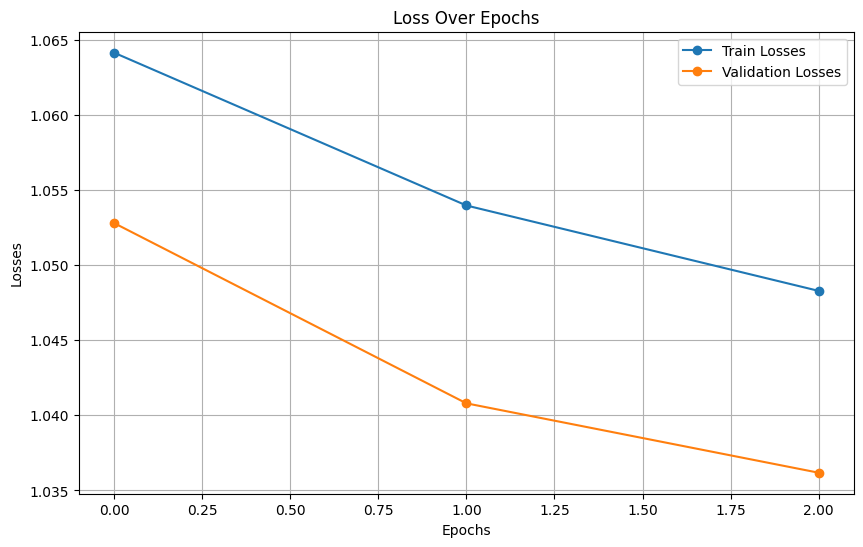

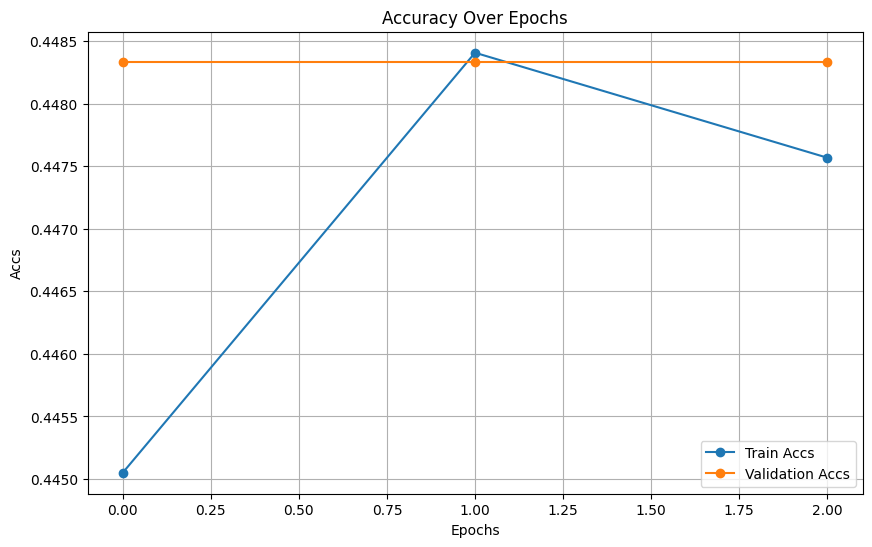

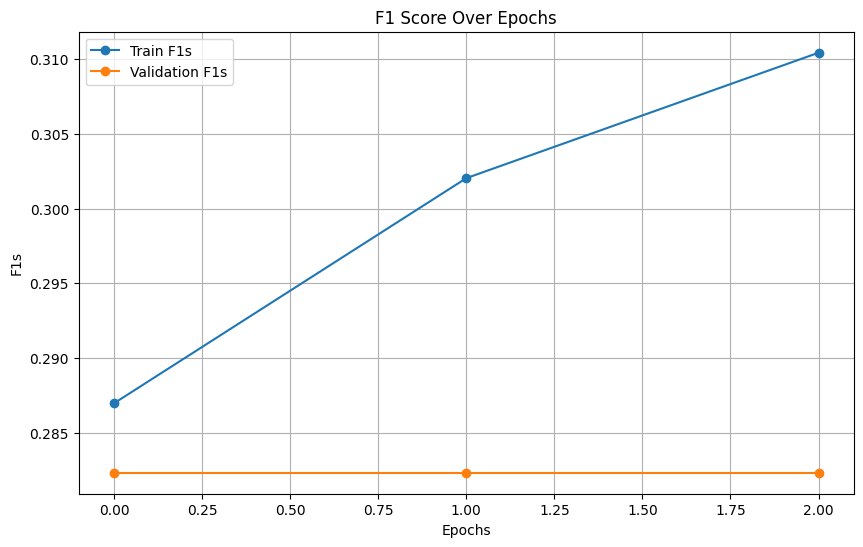

FileNotFoundError: Cannot find file: /content/loss_plot.png

In [ ]:
import gc
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Clear memory and reset GPU
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Initialize optimizer and learning rate scheduler
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-5, weight_decay=0.01)

# Define number of steps for scheduler
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = num_training_steps // 10

# Initialize scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Mixed precision training scaler
scaler = torch.amp.GradScaler('cuda')

# Training loop
num_epochs = 5
best_val_f1 = 0
metrics = {
    'train_losses': [], 'val_losses': [],
    'train_accs': [], 'val_accs': [],
    'train_f1s': [], 'val_f1s': [],
    'train_precisions': [], 'val_precisions': [],
    'train_recalls': [], 'val_recalls': []
}

print("\n=== Starting Training ===")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda'):
            outputs = model(**inputs)
            loss = outputs.loss / accumulation_steps
            logits = outputs.logits

        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        predictions = torch.argmax(logits, dim=1)
        train_true_labels.extend(inputs['labels'].cpu().numpy())
        train_pred_labels.extend(predictions.cpu().numpy())

    # Calculate training metrics
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')
    train_precision = precision_score(train_true_labels, train_pred_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(inputs['labels'].cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Update metrics
    metrics['train_losses'].append(train_loss / len(train_loader))
    metrics['val_losses'].append(val_loss / len(val_loader))
    metrics['train_accs'].append(train_accuracy)
    metrics['val_accs'].append(val_accuracy)
    metrics['train_f1s'].append(train_f1)
    metrics['val_f1s'].append(val_f1)
    metrics['train_precisions'].append(train_precision)
    metrics['val_precisions'].append(val_precision)
    metrics['train_recalls'].append(train_recall)
    metrics['val_recalls'].append(val_recall)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_f1': val_f1,
            'metrics': metrics
        }, 'best_model.pt')
        print(f"\nSaved new best model with F1 score: {val_f1:.4f}")

# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'metrics': metrics
}, 'final_model.pt')
print("\nFinal model saved as 'final_model.pt'")

# Download models

from google.colab import files
best_model_path = 'best_model.pt'
final_model_path = 'final_model.pt'
files.download(best_model_path)
files.download(final_model_path)



# Plot metrics
def plot_metrics(metrics, metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics[f'train_{metric_name}'], label=f'Train {metric_name.capitalize()}', marker='o')
    plt.plot(metrics[f'val_{metric_name}'], label=f'Validation {metric_name.capitalize()}', marker='o')
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

metrics_df = pd.DataFrame(metrics)
print("\n=== Metrics Table ===")
print(metrics_df)
metrics_csv_path = "/content/metrics_table.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
files.download(metrics_csv_path)



plot_metrics(metrics, 'losses', 'Loss')
plot_metrics(metrics, 'accs', 'Accuracy')
plot_metrics(metrics, 'f1s', 'F1 Score')

# Download plots
files.download('/content/loss_plot.png')
files.download('/content/accuracy_plot.png')
files.download('/content/f1_plot.png')




# **prediction part**

GPU memory available: 15.84 GB

=== Loading Dataset ===
Downloading...
From (original): https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC
From (redirected): https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC&confirm=t&uuid=f5ec6cf5-7e54-438d-b7c4-c2519c8007a6
To: /content/unlabeled_data.csv
100% 451M/451M [00:02<00:00, 173MB/s]
Dataset size: 42367 rows

=== Loading Tokenizer ===

=== Loading Model ===


<ipython-input-36-087fc11a9117>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Some weights of BertForSequen

Model loaded successfully.

=== Predicting Labels ===


Predicting Labels:   2%|▏         | 101/5296 [00:20<18:10,  4.76it/s]

Saved 800 predictions so far.


Predicting Labels:   4%|▍         | 200/5296 [00:41<22:43,  3.74it/s]

Saved 1600 predictions so far.


Predicting Labels:   6%|▌         | 301/5296 [01:02<22:46,  3.66it/s]

Saved 2400 predictions so far.


Predicting Labels:   8%|▊         | 401/5296 [01:23<20:49,  3.92it/s]

Saved 3200 predictions so far.


Predicting Labels:   9%|▉         | 500/5296 [01:45<24:09,  3.31it/s]

Saved 4000 predictions so far.


Predicting Labels:  11%|█▏        | 600/5296 [02:07<30:34,  2.56it/s]

Saved 4800 predictions so far.


Predicting Labels:  13%|█▎        | 700/5296 [02:30<31:00,  2.47it/s]

Saved 5600 predictions so far.


Predicting Labels:  15%|█▌        | 801/5296 [02:52<22:41,  3.30it/s]

Saved 6400 predictions so far.


Predicting Labels:  17%|█▋        | 901/5296 [03:14<22:55,  3.19it/s]

Saved 7200 predictions so far.


Predicting Labels:  19%|█▉        | 1000/5296 [03:36<38:04,  1.88it/s]

Saved 8000 predictions so far.


Predicting Labels:  21%|██        | 1100/5296 [03:58<28:30,  2.45it/s]

Saved 8800 predictions so far.


Predicting Labels:  23%|██▎       | 1200/5296 [04:20<27:58,  2.44it/s]

Saved 9600 predictions so far.


Predicting Labels:  25%|██▍       | 1300/5296 [04:43<34:25,  1.94it/s]

Saved 10400 predictions so far.


Predicting Labels:  26%|██▋       | 1400/5296 [05:05<38:29,  1.69it/s]

Saved 11200 predictions so far.


Predicting Labels:  28%|██▊       | 1500/5296 [05:28<28:51,  2.19it/s]

Saved 12000 predictions so far.


Predicting Labels:  30%|███       | 1600/5296 [05:50<29:29,  2.09it/s]

Saved 12800 predictions so far.


Predicting Labels:  32%|███▏      | 1700/5296 [06:13<43:42,  1.37it/s]

Saved 13600 predictions so far.


Predicting Labels:  34%|███▍      | 1800/5296 [06:36<29:49,  1.95it/s]

Saved 14400 predictions so far.


Predicting Labels:  36%|███▌      | 1901/5296 [06:59<24:14,  2.33it/s]

Saved 15200 predictions so far.


Predicting Labels:  38%|███▊      | 2000/5296 [07:22<45:01,  1.22it/s]

Saved 16000 predictions so far.


Predicting Labels:  40%|███▉      | 2101/5296 [07:45<24:13,  2.20it/s]

Saved 16800 predictions so far.


Predicting Labels:  42%|████▏     | 2200/5296 [08:07<29:41,  1.74it/s]

Saved 17600 predictions so far.


Predicting Labels:  43%|████▎     | 2300/5296 [08:31<45:33,  1.10it/s]

Saved 18400 predictions so far.


Predicting Labels:  45%|████▌     | 2400/5296 [08:54<29:21,  1.64it/s]

Saved 19200 predictions so far.


Predicting Labels:  47%|████▋     | 2500/5296 [09:17<29:20,  1.59it/s]

Saved 20000 predictions so far.


Predicting Labels:  49%|████▉     | 2600/5296 [09:41<45:16,  1.01s/it]

Saved 20800 predictions so far.


Predicting Labels:  51%|█████     | 2700/5296 [10:04<29:09,  1.48it/s]

Saved 21600 predictions so far.


Predicting Labels:  53%|█████▎    | 2800/5296 [10:27<28:47,  1.44it/s]

Saved 22400 predictions so far.


Predicting Labels:  55%|█████▍    | 2900/5296 [10:52<44:10,  1.11s/it]

Saved 23200 predictions so far.


Predicting Labels:  57%|█████▋    | 3000/5296 [11:15<27:21,  1.40it/s]

Saved 24000 predictions so far.


Predicting Labels:  59%|█████▊    | 3100/5296 [11:38<26:27,  1.38it/s]

Saved 24800 predictions so far.


Predicting Labels:  60%|██████    | 3200/5296 [12:03<38:57,  1.12s/it]

Saved 25600 predictions so far.


Predicting Labels:  62%|██████▏   | 3300/5296 [12:26<24:50,  1.34it/s]

Saved 26400 predictions so far.


Predicting Labels:  64%|██████▍   | 3400/5296 [12:49<25:04,  1.26it/s]

Saved 27200 predictions so far.


Predicting Labels:  66%|██████▌   | 3500/5296 [13:14<31:13,  1.04s/it]

Saved 28000 predictions so far.


Predicting Labels:  68%|██████▊   | 3600/5296 [13:37<22:41,  1.25it/s]

Saved 28800 predictions so far.


Predicting Labels:  70%|██████▉   | 3700/5296 [14:03<34:44,  1.31s/it]

Saved 29600 predictions so far.


Predicting Labels:  72%|███████▏  | 3800/5296 [14:26<21:03,  1.18it/s]

Saved 30400 predictions so far.


Predicting Labels:  74%|███████▎  | 3900/5296 [14:50<19:54,  1.17it/s]

Saved 31200 predictions so far.


Predicting Labels:  76%|███████▌  | 4000/5296 [15:15<29:14,  1.35s/it]

Saved 32000 predictions so far.


Predicting Labels:  77%|███████▋  | 4100/5296 [15:39<17:37,  1.13it/s]

Saved 32800 predictions so far.


Predicting Labels:  79%|███████▉  | 4200/5296 [16:03<16:19,  1.12it/s]

Saved 33600 predictions so far.


Predicting Labels:  81%|████████  | 4300/5296 [16:28<20:38,  1.24s/it]

Saved 34400 predictions so far.


Predicting Labels:  83%|████████▎ | 4400/5296 [16:52<13:47,  1.08it/s]

Saved 35200 predictions so far.


Predicting Labels:  85%|████████▍ | 4500/5296 [17:18<20:05,  1.51s/it]

Saved 36000 predictions so far.


Predicting Labels:  87%|████████▋ | 4600/5296 [17:42<11:20,  1.02it/s]

Saved 36800 predictions so far.


Predicting Labels:  89%|████████▊ | 4700/5296 [18:07<12:42,  1.28s/it]

Saved 37600 predictions so far.


Predicting Labels:  91%|█████████ | 4800/5296 [18:32<10:02,  1.22s/it]

Saved 38400 predictions so far.


Predicting Labels:  93%|█████████▎| 4900/5296 [18:56<06:45,  1.02s/it]

Saved 39200 predictions so far.


Predicting Labels:  94%|█████████▍| 5000/5296 [19:23<08:07,  1.65s/it]

Saved 40000 predictions so far.


Predicting Labels:  96%|█████████▋| 5100/5296 [19:47<03:31,  1.08s/it]

Saved 40800 predictions so far.


Predicting Labels:  98%|█████████▊| 5200/5296 [20:13<02:15,  1.42s/it]

Saved 41600 predictions so far.


Predicting Labels: 100%|██████████| 5296/5296 [20:34<00:00,  4.29it/s]


Prediction completed and saved!

=== Sample Predictions ===
                                                post  \
0  i've become aware of a fascinating conspiracy ...   
1  edit: i have been convinced that renewables sh...   
2  looking at individual humans, its easy to see ...   
3  edit: i reworded the first paragraph of the po...   
4  first, i must disclaim im not an economist ; i...   

                                             comment  predicted_label  
0  answer: we're not allowed to say the real grou...                1  
1  the difference is outlined in this report page...                1  
2  what i'm more trying to express is that even i...                1  
3  if elon uncensors and unbans many accounts or ...                1  
4  20 years is a lot of time to expand your labor...                2  


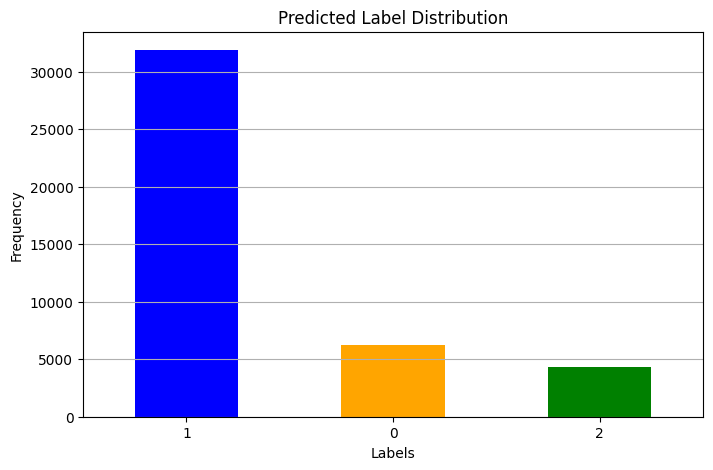


=== Label Distribution ===
predicted_label
1    31868
0     6202
2     4297
Name: count, dtype: int64


In [ ]:
import gc
import os
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from tqdm import tqdm

# Clear memory and reset GPU
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Dataset class with truncation handling
class UnlabeledDataset(Dataset):
    def __init__(self, posts, comments, tokenizer, max_length=512):
        self.posts = posts
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, idx):
        post = self.posts[idx]
        comment = self.comments[idx]

        # Truncate if necessary
        post = post[:self.max_length // 2]
        comment = comment[:self.max_length // 2]

        encoding = self.tokenizer(
            post,
            comment,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# Load the dataset
print("\n=== Loading Dataset ===")
!gdown "https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC"
data = pd.read_csv('unlabeled_data.csv')
print(f"Dataset size: {len(data)} rows")

# Check for NaN values
#print("\nChecking for NaN values:")
3#print(data.isnull().sum())

# Remove rows with NaN values
#data = data.dropna(subset=['cleaned_text', 'cleaned_body'])
#print(f"\nDataset size after removing NaN: {len(data)} rows")

# Prepare data
unlabeled_posts = data['cleaned_text'].tolist()
unlabeled_comments = data['cleaned_body'].tolist()

# Tokenizer initialization
print("\n=== Loading Tokenizer ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the dataset and DataLoader
unlabeled_dataset = UnlabeledDataset(unlabeled_posts, unlabeled_comments, tokenizer)
unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=8,  # Reduce batch size for large datasets
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

# Load the model
print("\n=== Loading Model ===")
checkpoint_path = 'best_model.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print("Model loaded successfully.")

# Initialize for intermediate saving
predicted_labels = []
start_index = 0

# Check if intermediate results exist
if os.path.exists('predicted_labels_intermediate.csv'):
    intermediate_df = pd.read_csv('predicted_labels_intermediate.csv')
    predicted_labels = intermediate_df['predicted_label'].tolist()
    start_index = len(predicted_labels)
    print(f"Resuming from {start_index} predictions...")

# Adjust DataLoader to skip completed items
unlabeled_dataset = UnlabeledDataset(unlabeled_posts[start_index:], unlabeled_comments[start_index:], tokenizer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

# Prediction loop with intermediate saves
print("\n=== Predicting Labels ===")
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(unlabeled_loader, desc="Predicting Labels")):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        predicted_labels.extend(predictions.cpu().numpy())

        # Save intermediate results every 100 batches
        if (batch_idx + 1) % 100 == 0:
            intermediate_df = pd.DataFrame({
                'post': unlabeled_posts[:len(predicted_labels)],
                'comment': unlabeled_comments[:len(predicted_labels)],
                'predicted_label': predicted_labels
            })
            intermediate_df.to_csv('predicted_labels_intermediate.csv', index=False)
            print(f"Saved {len(predicted_labels)} predictions so far.")

# Save final results
predicted_df = pd.DataFrame({
    'post': unlabeled_posts,
    'comment': unlabeled_comments,
    'predicted_label': predicted_labels
})
predicted_df.to_csv('predicted_labels.csv', index=False)
print("Prediction completed and saved!")

# Analyze and plot results
print("\n=== Sample Predictions ===")
print(predicted_df.head())

# Plot label distribution
import matplotlib.pyplot as plt
label_counts = predicted_df['predicted_label'].value_counts()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Predicted Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

print("\n=== Label Distribution ===")
print(label_counts)


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch

# Define a dataset class for unlabeled data
class UnlabeledDataset(Dataset):
    def __init__(self, posts, comments, tokenizer, max_length=512):
        self.posts = posts
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.posts[idx],
            self.comments[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}




#load dataset
#url: https://drive.google.com/file/d/1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC/view?usp=drive_link

!gdown "https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC"
data = pd.read_csv('unlabeled_data.csv')
print(f"Dataset size: {len(data)} rows")

# Check for NaN values
print("\nChecking for NaN values:")
print(data.isnull().sum())

# Remove rows with NaN values
data = data.dropna(subset=['cleaned_text', 'cleaned_body', 'label_agreement'])
print(f"\nDataset size after removing NaN: {len(data)} rows")

# Prepare data
unlabeled_posts = data['cleaned_text'].tolist()
unlabeled_comments = data['cleaned_body'].tolist()




# Prepare the dataset
#unlabeled_posts =   # Your 42,000 posts
#unlabeled_comments =  # Your 42,000 comments


unlabeled_dataset = UnlabeledDataset(unlabeled_posts, unlabeled_comments, tokenizer)

# DataLoader for unlabeled data
unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True,
    num_workers=1
)

# Load the best model
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Predict labels for the unlabeled data
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(unlabeled_loader, desc="Predicting Labels"):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        predicted_labels.extend(predictions.cpu().numpy())

# Save predicted labels
import pandas as pd
predicted_df = pd.DataFrame({
    'post': unlabeled_posts,
    'comment': unlabeled_comments,
    'predicted_label': predicted_labels
})
predicted_df.to_csv('predicted_labels.csv', index=False)

print("Prediction completed and saved!")
